 # **Extracting Information from Legal Documents Using RAG**

 ## **Objective**

 The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:



 * Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.

 * Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.

 * Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.

 * Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.

 * Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.



 The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

 ### **Business Value**



 The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:



 * Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.

 * Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.

 * Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.

 * Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.





 **Use Cases**

 * Legal Chatbots

 * Contract Review Automation

 * Tracking Regulatory Changes and Compliance Monitoring

 * Case Law Analysis of past judgments

 * Due Diligence & Risk Assessment

 ## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

 ### **1.1 Data Understanding**

 The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.



 There are four types of documents in the *courpus* folder, divided into four subfolders.

 - `contractnli`: contains various non-disclosure and confidentiality agreements

 - `cuad`: contains contracts with annotated legal clauses

 - `maud`: contains various merger/acquisition contracts and agreements

 - `privacy_qa`: a question-answering dataset containing privacy policies



 The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:



 ```

 {

     "tests": [

         {

             "query": <question1>,

             "snippets": [{

                     "file_path": <source_file1>,

                     "span": [ begin_position, end_position ],

                     "answer": <relevant answer to the question 1>

                 },

                 {

                     "file_path": <source_file2>,

                     "span": [ begin_position, end_position ],

                     "answer": <relevant answer to the question 2>

                 }, ....

             ]

         },

         {

             "query": <question2>,

             "snippets": [{<answer context for que 2>}]

         },

         ... <more queries>

     ]

 }

 ```

 ### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

 #### Loading libraries

In [1]:
# # The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score
# !pip install -q evaluate # For BLEU score
# !pip install -q nltk
# !pip install -q scikit-learn
# !pip install -q tqdm
# !pip install -q pandas
# !pip install -q numpy
# !pip install -q matplotlib
# !pip install -q seaborn
# !pip install -q pathlib


In [2]:
# %%
# import essential libraries
import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
from tqdm import tqdm
import random
import shutil

import warnings
warnings.filterwarnings('ignore')

# Langchain imports
from langchain.document_loaders import DirectoryLoader # Keep if you used it initially, TextLoader is used in your load_documents_from_corpus
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.docstore.document import Document
# from pathlib import Path # Already imported
from langchain.document_loaders import TextLoader # Used in your load_documents_from_corpus

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# scikit-learn for TF-IDF and similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Evaluation libraries
from rouge_score import rouge_scorer
import evaluate as hf_evaluate # For BLEU score (aliased)
from ragas import evaluate as ragas_evaluate # For RAGAS (aliased)
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness
)
from datasets import Dataset # For RAGAS

# ensure NLTK resources are available
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

print("Libraries imported and NLTK resources checked.")
# Make sure your OPENAI_API_KEY is set in your environment
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    print("CRITICAL: OpenAI API Key not found. RAG and RAGAS evaluation will likely fail.")
else:
    print("OpenAI API Key found.")

Libraries imported and NLTK resources checked.
OpenAI API Key found.


 #### **1.2.1** <font color=red> [3 marks] </font>

 Load all `.txt` files from the folders.

 You can utilise document loaders from the options provided by the LangChain community.



 Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
from pathlib import Path
from langchain.document_loaders import TextLoader
from tqdm import tqdm

def load_documents_from_corpus(corpus_dir_path):
    """
    recursively loads all clean .txt files from the corpus directory.
    this processes all txt files found in the directory structure.
    """
    corpus_path = Path(corpus_dir_path)
    all_documents = []

    print(f"starting recursive loading from: {corpus_path}")

    # find all .txt files, excluding macos metadata
    txt_files = [f for f in corpus_path.rglob("*.txt") if not f.name.startswith("._")]

    print(f"found {len(txt_files)} .txt files to process.")

    for file_path in tqdm(txt_files, desc="loading txt files"):
        try:
            loader = TextLoader(str(file_path), autodetect_encoding=True)
            docs = loader.load()
            
            if not docs:
                continue

            for doc in docs:
                if not doc.page_content.strip():
                    # skip empty content
                    continue

                # useful metadata for tracking
                doc.metadata['filename'] = file_path.name
                # store relative path from corpus root
                doc.metadata['relative_path'] = str(file_path.relative_to(corpus_path))
                doc.metadata['file_path'] = str(file_path)

                all_documents.append(doc)

        except Exception as e:
            print(f"error loading {file_path}: {e}")

    print(f"successfully loaded {len(all_documents)} documents from {len(txt_files)} files.")
    return all_documents


In [4]:
print("LOADING ALL DOCUMENTS")
corpus_data_path = Path('./rag_legal')
documents = load_documents_from_corpus(corpus_data_path)

LOADING ALL DOCUMENTS
starting recursive loading from: rag_legal
found 698 .txt files to process.


loading txt files: 100%|██████████| 698/698 [00:01<00:00, 515.68it/s]

successfully loaded 698 documents from 698 files.


 #### **1.2.2** <font color=red> [2 marks] </font>

 Preprocess the text data to remove noise and prepare it for analysis.

 Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.

 Normalise text (e.g., convert to lowercase, remove stop words).

 Handle missing or corrupted data by logging errors and skipping problematic files.

In [5]:
# normalize horizontal and vertical whitespaces
import re
def clean_document_text(text, remove_stop_words=False, to_lowercase=True):
    """
    Cleans and preprocesses legal document text.
    
    Handles:
    - Removes emails and phone numbers
    - Normalizes unicode characters
    - Splits camelCase and PascalCase words
    - Separates letters and numbers
    - Optionally converts to lowercase
    - Optionally removes stop words
    - Normalizes multiple newlines to double newlines (for paragraph breaks)
    - Normalizes other whitespace (spaces, tabs) to single spaces
    - Cleans most special characters (preserving some legal/common ones)
    - Final strip of leading/trailing whitespace
    """
    
    if not isinstance(text, str) or not text.strip():
        return ""

    try:
        # step 1: remove emails and phone numbers
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' ', text) # case-insensitive email
        text = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', text)
        text = re.sub(r'\(\d{3}\)\s*\d{3}[-.\s]?\d{4}', ' ', text)
        text = re.sub(r'\+\d{1,3}[\s-]?\(?\d{1,4}\)?[\s-]?\d{3,4}[\s-]?\d{3,4}', ' ', text)

        # step 2: normalize unicode quotes, dashes, and special spaces
        text = re.sub(r'["“”（`‘’‛‟„‚“”—–]', '"', text) # normalize quotes and dashes to standard double quote
        text = text.replace('\u2013', '-') # dash to hyphen
        text = text.replace('\u2014', '--') # dash to double hyphen
        text = text.replace('\xa0', ' ') 
        text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)

        # step 3: split camelCase, PascalCase, and letter/number joins
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
        text = re.sub(r'([A-Z])([A-Z][a-z])', r'\1 \2', text)
        text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
        text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)

        # step 4: lowercase the entire text if requested
        if to_lowercase:
            text = text.lower()
        
        # step 5: (skipping commented-out joined word splitting for now)

        # step 6: clean special characters but preserve important legal/common symbols.
        text = re.sub(r'[^\w\s\.\,\;\:\!\?\(\)\"\'\-\$\€\£\¥§%©®]', ' ', text)

        # step 7: whitespace normalization
        # 7a: normalize multiple newlines (3 or more) to double newlines
        text = re.sub(r'\n{3,}', '\n\n', text)
        # 7b: normalize sequences of spaces and tabs to a single space
        text = re.sub(r'[ \t\f\v\r]+', ' ', text)
        # 7c: convert single newlines 
        # text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)

        # 7d: clean up spaces around newlines
        text = re.sub(r'\s*\n\s*', '\n', text).strip('\n') # strip leading/trailing newlines from the whole text here before final strip

        # step 8: optionally remove stop words
        if remove_stop_words:
            stop_words_set = set(stopwords.words('english'))
            words = text.split()
            filtered_words = []
            for w in words:
                
                if (w not in stop_words_set or 
                    w.isdigit() or
                    w in ['shall', 'may', 'must', 'agreement', 'contract', 'party', 'parties']): # Example important words
                    filtered_words.append(w)
            text = ' '.join(filtered_words)

        # Step 9: final strip of any leading/trailing whitespace
        return text.strip()

    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""

In [6]:
def preprocess_loaded_documents(loaded_documents, remove_stop_words = False, to_lowercase = True, min_length = 100):
    """
    applies cleaning to the page_content of each document object according to your requirements.
    this processes all documents in the input list and handles missing/corrupted data.
    
    parameters:
    - loaded_documents: list of document objects to process
    - remove_stop_words: whether to remove stop words (False recommended for RAG)
    - to_lowercase: whether to convert to lowercase (True follows your requirements)
    - min_length: minimum character length to keep document (default: 100 for RAG)
    
    handles corrupted data by:
    - logging errors for problematic files
    - skipping documents that can't be processed
    - skipping documents that become too short after cleaning
    """
    processed_documents = []
    skipped_count = 0
    error_count = 0
    
    if not loaded_documents:
        print("no documents to preprocess.")
        return []

    # display processing configuration
    stop_word_status = "removing stop words" if remove_stop_words else "keeping stop words"
    case_status = "converting to lowercase" if to_lowercase else "preserving original case"
    
    print(f"starting preprocessing for {len(loaded_documents)} documents...")
    print(f"configuration: {stop_word_status}, {case_status}")
    print(f"minimum document length: {min_length} characters")
    
    for doc in tqdm(loaded_documents, desc="preprocessing documents"):
        try:
            # attempt to clean the document content
            cleaned_content = clean_document_text(
                doc.page_content, 
                remove_stop_words=remove_stop_words,
                to_lowercase=to_lowercase
            )
            
            # skip if document is too short after cleaning
            if len(cleaned_content) < min_length:
                skipped_count += 1
                continue
                
            # create a new document object with cleaned content
            processed_doc = type(doc)(
                page_content=cleaned_content,
                metadata=doc.metadata  # retain original metadata
            )
            processed_documents.append(processed_doc)
            
        except Exception as e:
            # handle missing or corrupted data by logging and skipping
            filename = doc.metadata.get('filename', 'unknown')
            print(f"error processing {filename}: {e}")
            error_count += 1
            continue
        
    print(f"successfully preprocessed {len(processed_documents)} documents.")
    if skipped_count > 0:
        print(f"skipped {skipped_count} documents that were too short after cleaning.")
    if error_count > 0:
        print(f"encountered errors in {error_count} documents (logged and skipped).")
    
    return processed_documents

In [7]:
# RAG optimized cleanup
processed_documents = preprocess_loaded_documents(
    documents, 
    remove_stop_words=False,  # better for rag
    to_lowercase=True,        # normalize text
    min_length=100
)


starting preprocessing for 698 documents...
configuration: keeping stop words, converting to lowercase
minimum document length: 100 characters


preprocessing documents: 100%|██████████| 698/698 [00:07<00:00, 97.39it/s] 

successfully preprocessed 698 documents.


In [8]:
# show first 3 samples
for i, doc in enumerate(processed_documents[:3]):
    print(f"\n--- document {i+1} ---\n")
    print(f"filename: {doc.metadata.get('filename', 'unknown')}")
    print(f"path:     {doc.metadata.get('file_path', 'unknown')}\n")
    print(f"Metadata: {doc.metadata}\n")
    print("content sample:")
    print(doc.page_content[:500])  # print first 500 chars of the cleaned content
    print('\n')



--- document 1 ---

filename: Groupon.txt
path:     rag_legal/corpus/privacy_qa/Groupon.txt

Metadata: {'source': 'rag_legal/corpus/privacy_qa/Groupon.txt', 'filename': 'Groupon.txt', 'relative_path': 'corpus/privacy_qa/Groupon.txt', 'file_path': 'rag_legal/corpus/privacy_qa/Groupon.txt'}

content sample:
we will collect information, including personal informationand non-identifying information, when you interact with us and the site, for example when you:
access or use the site;
register, subscribe, or create an account with groupon;
open or respond to our e-mails;
refer friends, family, or others to groupon;
contact customer service or use other customer support tools;
provide information to enroll or participate in other programsprovided on behalf of, or together with,business partners;
visit 



--- document 2 ---

filename: Fiverr.txt
path:     rag_legal/corpus/privacy_qa/Fiverr.txt

Metadata: {'source': 'rag_legal/corpus/privacy_qa/Fiverr.txt', 'filename': 'Fiverr.txt', 'relativ

 ### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

 #### **1.3.1** <font color=red> [1 marks] </font>

 Calculate the average, maximum and minimum document length.

--- Document Length Statistics ---
Total Documents: 698
Average Length: 102447.15 characters
Median Length: 37622.50 characters
Maximum Length: 985629 characters
Minimum Length: 1442 characters
Standard Deviation: 131937.28 characters


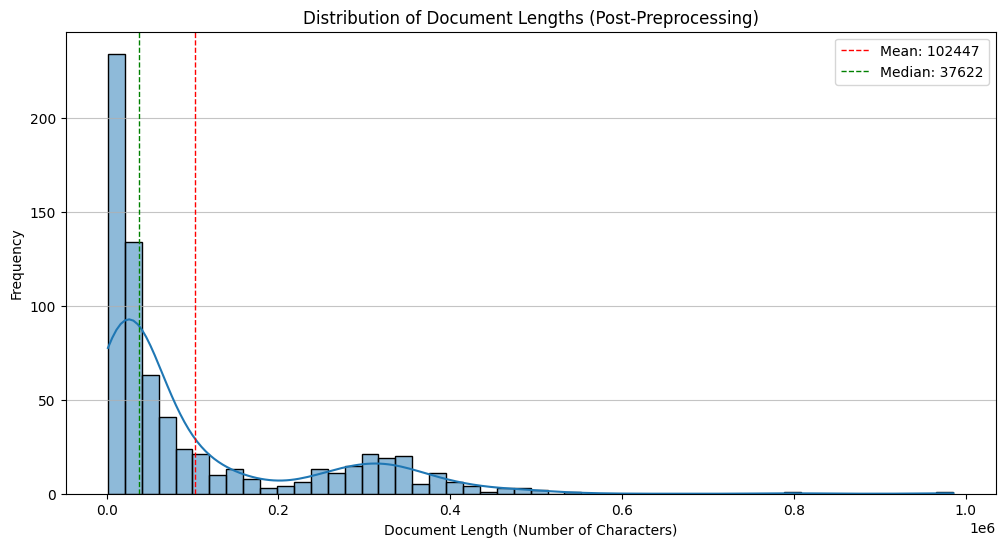

In [9]:
# calculate avg, max and min document length.
def display_document_length_stats(docs):
    """
    Calculates and displays statistics about document lengths and plots a histogram.
    """
    if not docs:
        print("No documents to analyze for length statistics.")
        return

    doc_lengths = [len(doc.page_content) for doc in docs]
    
    avg_length = np.mean(doc_lengths)
    max_length = np.max(doc_lengths)
    min_length = np.min(doc_lengths)
    median_length = np.median(doc_lengths)
    std_dev_length = np.std(doc_lengths)
    
    print("--- Document Length Statistics ---")
    print(f"Total Documents: {len(doc_lengths)}")
    print(f"Average Length: {avg_length:.2f} characters")
    print(f"Median Length: {median_length:.2f} characters")
    print(f"Maximum Length: {max_length} characters")
    print(f"Minimum Length: {min_length} characters")
    print(f"Standard Deviation: {std_dev_length:.2f} characters")
    
    # Plotting the distribution of document lengths
    plt.figure(figsize=(12, 6))
    sns.histplot(doc_lengths, bins=50, kde=True)
    plt.title('Distribution of Document Lengths (Post-Preprocessing)')
    plt.xlabel('Document Length (Number of Characters)')
    plt.ylabel('Frequency')
    plt.axvline(avg_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {avg_length:.0f}')
    plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.0f}')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

display_document_length_stats(processed_documents)

 #### **1.3.2** <font color=red> [4 marks] </font>

 Analyse the frequency of occurrence of words and find the most and least occurring words.

 Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [10]:
# frequency of occurence of words
def analyze_word_frequencies(docs: list[Document], top_n: int = 20):
    """
    Analyzes word frequencies across all documents, excluding stop words.
    Displays the most and least common words and plots their frequencies.
    """
    if not docs:
        print("No documents to analyze for word frequencies.")
        return

    # NLTK stop words
    stop_words = set(stopwords.words('english'))
    
    # custom stop words relevant to legal/general documents
    custom_stop_words = {
        'shall', 'may', 'agreement', 'company', 'party', 'parties', 'inc', 'corp', 'llc',
        'contract', 'section', 'article', 'clause', 'exhibit', 'appendix', 'schedule',
        'pursuant', 'hereto', 'herein', 'thereof', 'hereunder', 'including', 'com',
        'www', 'http', 'https', 'also', 'therein', 'thereon', 'thereby', 'therefor',
        'therefrom', 'notwithstanding', 'provided', 'however', 'unless', 'thereunder',
        'information', 'confidential', 'services', 'date', 'term', 'year', 'time',
        'defined', 'set', 'forth', 'terms', 'conditions', 'rights', 'obligations',
        'notice', 'written', 'consent', 'law', 'laws', 'business', 'use', 'used',
        'service', 'product', 'products', 'data', 'content', 'user', 'users',
        'effective', 'date', 'title', 'page', 'contents', 'table', 'fig', 'figure'
    }
    stop_words.update(custom_stop_words)

    all_words = []
    print("Tokenizing and filtering words for frequency analysis...")
    for doc in tqdm(docs, desc="Processing documents for word frequency"):
        tokens = word_tokenize(doc.page_content)  # page_content is already lowercased
        # filter for alphabetic words, not in stop_words, and length > 2
        filtered_tokens = [
            word for word in tokens 
            if word.isalpha() and word.lower() not in stop_words and len(word) > 2

        ]
        all_words.extend(filtered_tokens)

    if not all_words:
        print("No words found after filtering. Check stop word list or document content.")
        return

    word_counts = Counter(all_words)
    
    most_common_words = word_counts.most_common(top_n)
    # for least common, ensure we handle cases with fewer unique words than top_n
    least_common_words = sorted(word_counts.items(), key=lambda item: item[1])[:top_n]

    print(f"\n--- Top {top_n} Most Common Words (excluding stop words) ---")
    for word, count in most_common_words:
        print(f"{word}: {count}")

    print(f"\n--- Top {top_n} Least Common Words (excluding stop words, occurring at least once) ---")
    for word, count in least_common_words:
        print(f"{word}: {count}")

    # visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Most common
    words_mc, counts_mc = zip(*most_common_words)
    axes[0].barh(list(words_mc)[::-1], list(counts_mc)[::-1], color='skyblue')
    axes[0].set_title(f'Top {top_n} Most Common Words')
    axes[0].set_xlabel('Frequency')
    
    # least common
    words_lc, counts_lc = zip(*least_common_words)
    axes[1].barh(list(words_lc), list(counts_lc), color='lightcoral') # No need to reverse for least common
    axes[1].set_title(f'Top {top_n} Least Common Words (Min. 1 occurrence)')
    axes[1].set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()


Tokenizing and filtering words for frequency analysis...


Processing documents for word frequency: 100%|██████████| 698/698 [00:20<00:00, 34.32it/s] 



--- Top 20 Most Common Words (excluding stop words) ---
parent: 60660
material: 34216
merger: 33852
subsidiaries: 33320
applicable: 31371
respect: 28848
stock: 26652
prior: 23341
shares: 22158
required: 21252
except: 20379
effect: 20019
person: 18658
reasonably: 18658
otherwise: 18380
would: 18122
subject: 17747
termination: 15756
made: 15415
means: 15391

--- Top 20 Least Common Words (excluding stop words, occurring at least once) ---
programsprovided: 1
toolor: 1
daa: 1
datato: 1
choicespage: 1
datawith: 1
sourcesto: 1
dealsprogram: 1
informationof: 1
affiliatewho: 1
vendorsto: 1
partnersto: 1
informationobtained: 1
partnersfor: 1
partnerson: 1
informationabout: 1
cookiesor: 1
visithttp: 1
informationduring: 1
dataand: 1


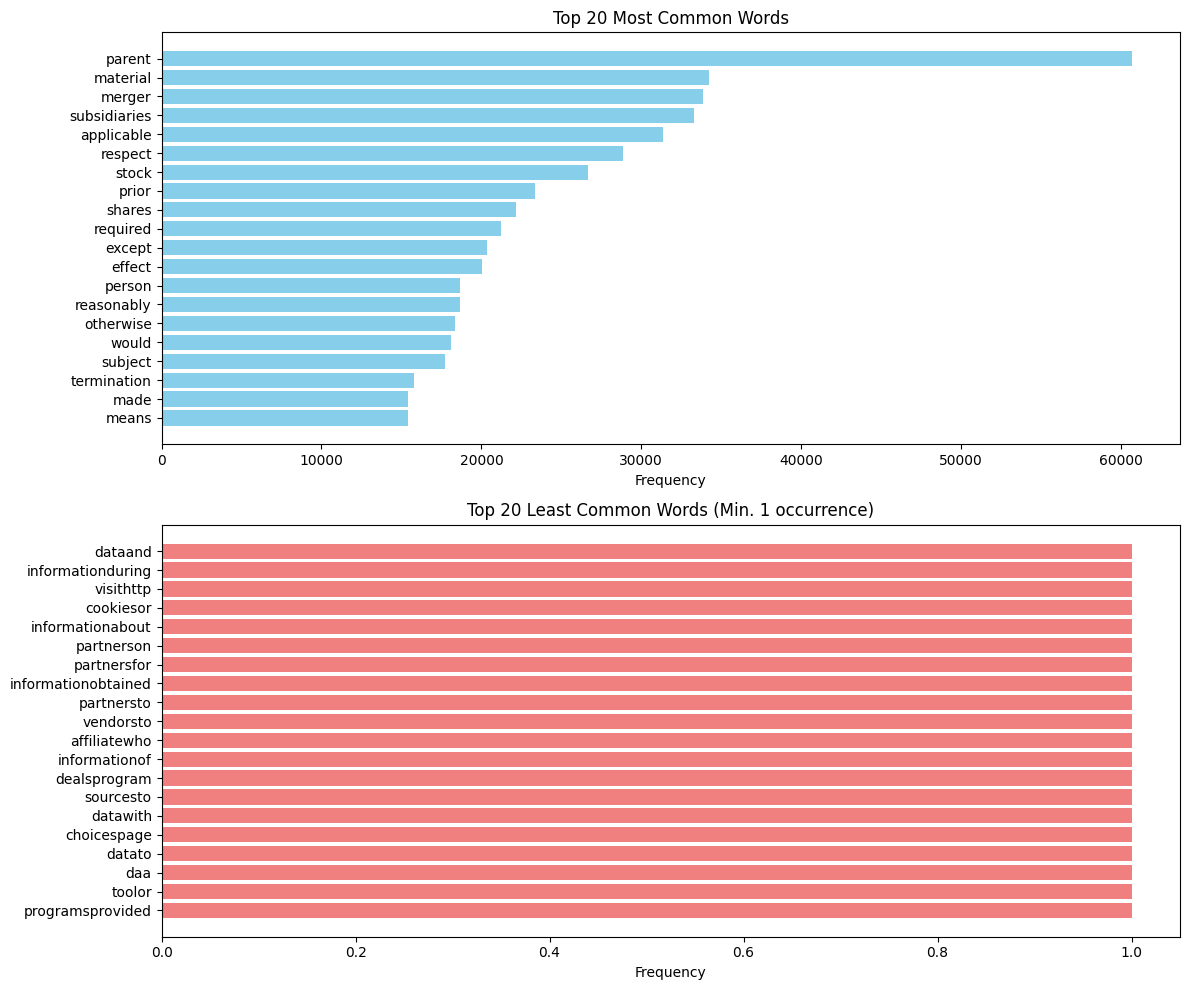

In [11]:
analyze_word_frequencies(processed_documents)

 #### **1.3.3** <font color=red> [4 marks] </font>

 Analyse the similarity of different documents to each other based on TF-IDF vectors.

 Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.



 Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [12]:
# transform the page contents of documents
def analyze_document_similarity_tfidf(docs, indices = None, description = ""):
    """
    Calculates and visualizes document similarity using TF-IDF and cosine similarity.
    If indices is None, uses the first 10 documents. Otherwise, uses documents at specified indices.
    """
    if not docs:
        print("No documents to analyze for similarity.")
        return

    if indices is None:
        sample_docs = docs[:10]
        doc_labels = [f"Doc{i}_{d.metadata.get('filename', 'N/A')[:15]}" for i, d in enumerate(sample_docs)]
        title_desc = "First 10 Documents"
    else:
        if not all(0 <= idx < len(docs) for idx in indices):
            print("Error: Provided indices are out of bounds.")
            return
        sample_docs = [docs[i] for i in indices]
        doc_labels = [f"Doc{i}_{d.metadata.get('filename', 'N/A')[:15]}" for i, d in enumerate(sample_docs)]
        title_desc = description if description else f"Documents at Indices: {indices}"

    if len(sample_docs) < 2:
        print(f"Not enough documents ({len(sample_docs)}) to compare for similarity in '{title_desc}'. Need at least 2.")
        return

    print(f"\nAnalyzing TF-IDF similarity for: {title_desc}")
    
    page_contents = [doc.page_content for doc in sample_docs]

    # initialize TF-IDF Vectorizer
    # using more features to capture more nuance, but can be tuned
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=2, max_df=0.95)
    tfidf_matrix = vectorizer.fit_transform(page_contents)

    # calculate Cosine Similarity
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # plotting the similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap="viridis", fmt=".2f", 
                xticklabels=doc_labels, yticklabels=doc_labels)
    plt.title(f'TF-IDF Document Similarity Matrix ({title_desc})')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    


Analyzing TF-IDF similarity for: First 10 Documents


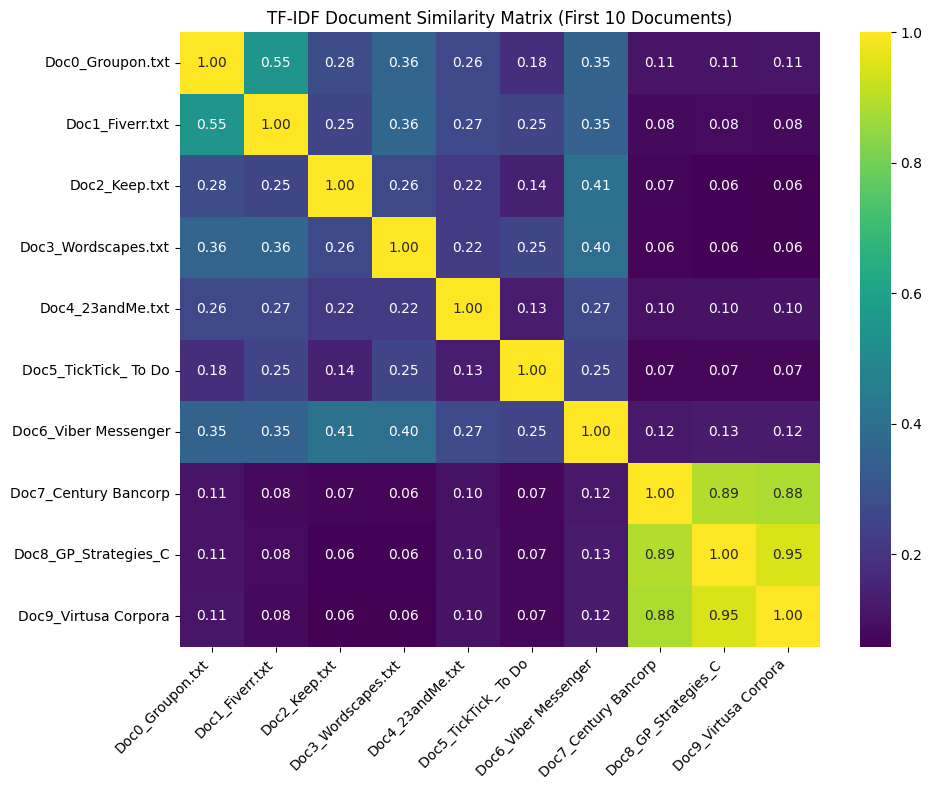

In [13]:
# compute similarity scores for the first 10 documents
analyze_document_similarity_tfidf(processed_documents, description="First 10 Documents")

**Observations for: TF-IDF Document Similarity Matrix (First 10 Documents)**

*   A very strong cluster of high similarity persists among **Doc7 (Century Bancorp)**, **Doc8 (GP\_Strategies\_C)**, and **Doc9 (Virtusa Corpora)**, with scores consistently between **0.88 and 0.95**. This reaffirms they likely share substantial identical or near-identical legal text, common in series of related corporate or financial agreements.
*   Moderate similarity is noted between **Doc0 (Groupon.txt)** and **Doc1 (fiverr.txt)** at **0.55**, and also between **Doc2 (Keep.txt)** and **Doc6 (Viber Messenger)** at **0.41**. These pairings suggest shared terminology or clauses common in online service agreements, privacy policies, or general tech-related contracts.
*   The documents outside the main Doc7-9 cluster (i.e., Docs 0-6) generally exhibit low similarity scores (many below 0.30) with each other and very low similarity (around 0.10) with the Doc7-9 cluster, indicating significant lexical diversity in this initial sequential sample.
*   The diagonal shows perfect self-similarity (1.00), and the matrix is symmetrical, as expected for cosine similarity.


Selected random indices: [38, 674, 457, 671, 62, 512, 672, 210, 419, 574]

Analyzing TF-IDF similarity for: 10 Randomly Selected Documents


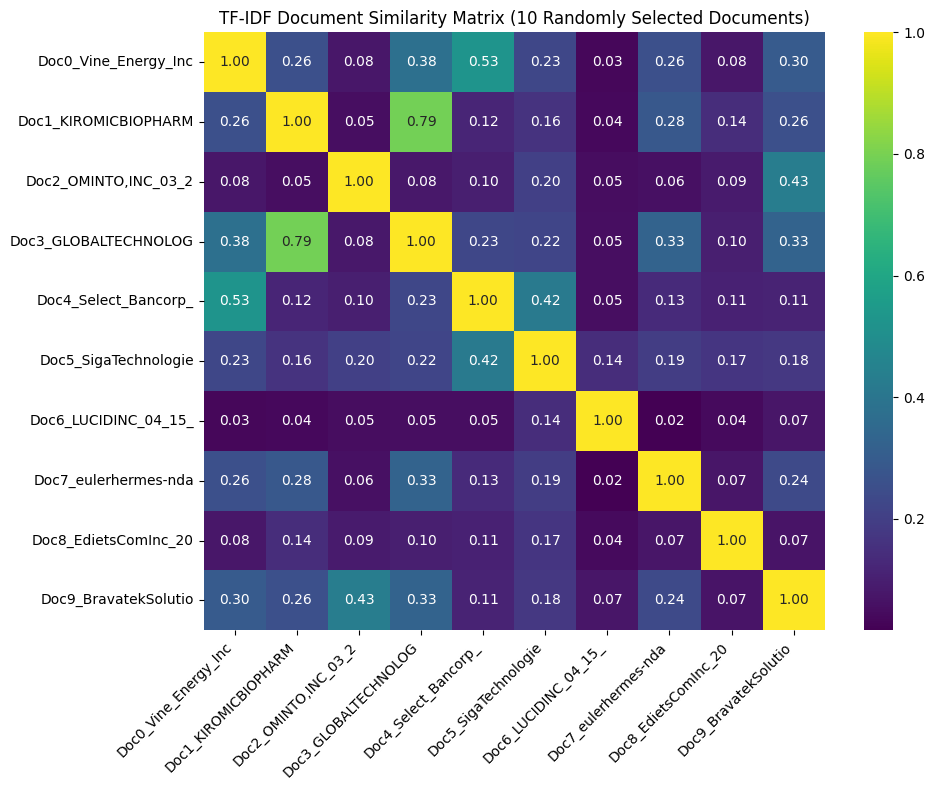

In [14]:
# create a list of 10 random integers
num_random_docs = 10
if len(processed_documents) >= num_random_docs: # Use processed_documents
    random_indices = random.sample(range(len(processed_documents)), num_random_docs) # Use processed_documents
    print(f"\nSelected random indices: {random_indices}")
    # Compute similarity scores for 10 random documents
    analyze_document_similarity_tfidf(processed_documents, indices=random_indices, description="10 Randomly Selected Documents")
else:
    print(f"\nNot enough documents ({len(processed_documents)}) to select {num_random_docs} random ones. Skipping random similarity analysis.")

**Observations for: TF-IDF Document Similarity Matrix (10 Randomly Selected Documents)**

*   This random sample shows a more dispersed similarity pattern compared to the first 10 documents. The highest off-diagonal similarity is between **Doc1 (KIROMICBIOPHARM)** and **Doc3 (GLOBALTECHNOLOG)** at **0.79**, suggesting these two randomly selected documents might come from a similar industry (e.g., biotech/pharma with technology aspects) or deal with similar contractual frameworks.
*   **Doc0 (Vine\_Energy\_Inc)** and **Doc4 (Select\_Bancorp\_)** show a moderate similarity of **0.53**. Other moderate pairings include **Doc2 (OMINTO,INC\_03\_2)** with **Doc9 (BravatekSolutio)** at **0.43**. These suggest some shared vocabulary or themes, possibly related to corporate structure or specific types of agreements within their respective sectors.
*   Many document pairs exhibit very low similarity scores (numerous values below 0.20, e.g., **Doc6 (LUCIDINC\_04\_15\_)** with most others), highlighting the broad topical and lexical diversity present across the entire corpus when documents are selected randomly.
*   Unlike the first plot, there isn't one dominant, very tight cluster, but rather a few moderate connections, reinforcing the idea that while specific similar document types exist, the overall corpus is varied.

 ### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

 #### **1.4.1** <font color=red> [5 marks] </font>

 Perform appropriate steps to split the text into chunks.

In [15]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from tqdm import tqdm


def create_document_chunks(processed_docs,
                           chunk_size = 1200,
                           chunk_overlap = 250,
                           min_chunk_char_length = 50,
                           verbose = False):
    """
    splits documents into smaller, overlapping chunks using RecursiveCharacterTextSplitter.
    assumes documents have already been adequately cleaned by clean_document_text.
    retains metadata from the original document for each chunk.
    """
    if not processed_docs:
        print("No documents provided for chunking.")
        return []

    # define separators
    legal_separators = [
        "\n\nARTICLE I.", "\n\nARTICLE II.", "\n\nARTICLE III.", 
        "\n\nSection 1.", "\n\nSection 2.", "\n\nSection 1.1.", 
        "\n\nEXHIBIT A:", "\n\nEXHIBIT B:", 
        "\n\nAPPENDIX 1:", "\n\nAPPENDIX A:",
        "\n\nRECITALS:", "\nRECITALS:",
        "\n\nWHEREAS,", "\nWHEREAS,",
        "\n\nNOW, THEREFORE,", "\nNOW, THEREFORE,",
        "\n\nIT IS HEREBY AGREED AS FOLLOWS:",
        "\n\nIN WITNESS WHEREOF,",
        "\n1.", "\n2.", "\n(a)", "\n(b)", "\n(i)", "\n(ii)",
        "\n\n\n", "\n\n", "\n",
        ". ", ".\n", "? ", "!\n",
        " ", ""
    ]

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=legal_separators,
        is_separator_regex=False,
        keep_separator=False
    )

    all_chunks = []
    print(f"Starting chunking for {len(processed_docs)} documents with chunk_size={chunk_size}, chunk_overlap={chunk_overlap}...")

    for doc_idx, doc in enumerate(tqdm(processed_docs, desc="Chunking documents")):
        # The content from processed_docs is already cleaned by clean_document_text
        content_for_splitting = doc.page_content 

        if not content_for_splitting.strip(): # Check if content is empty after main cleaning
            if verbose: print(f"Skipping document {doc.metadata.get('filename', 'N/A')} as its content is empty.")
            continue

        # create a Document object to pass to the splitter, preserving original metadata.
        # no need for temp_doc_for_splitting if doc itself is the right input type and content.
        # splitter's split_documents method takes a list of Document objects.
        
        try:
            # Pass the original doc (which has the cleaned page_content) directly
            # The splitter will operate on doc.page_content and copy metadata.
            chunks_from_doc = text_splitter.split_documents([doc]) 
        except Exception as e:
            print(f"Error splitting document {doc.metadata.get('filename', 'N/A')}: {e}")
            continue
            
        for chunk_idx, chunk in enumerate(chunks_from_doc):
            chunk_content = chunk.page_content.strip() 

            if len(chunk_content) < min_chunk_char_length or len(chunk_content.split()) < 5:
                if verbose: print(f"Skipping short chunk from {chunk.metadata.get('filename', 'N/A')}: '{chunk_content[:50]}...'")
                continue
            
            # Metadata from the original 'doc' should be automatically copied to each 'chunk'
            chunk.metadata['filename'] = doc.metadata.get('filename', 'Unknown') # Ensure filename consistency
            chunk.metadata['chunk_number'] = chunk_idx + 1
            chunk.metadata['total_chunks_in_doc'] = len(chunks_from_doc)
            # 'relative_path' and 'file_path' should already be in chunk.metadata if they were in doc.metadata

            all_chunks.append(chunk)

    if not all_chunks:
        print("No chunks were generated. Check documents, cleaning, and splitter settings.")
        return []

    print(f"\nSuccessfully generated {len(all_chunks)} chunks from {len(processed_docs)} documents.")

    # Analyze chunk lengths
    chunk_lengths = [len(chunk.page_content) for chunk in all_chunks]
    if chunk_lengths: # Ensure not empty before calculating stats
        print(f"Average chunk length: {np.mean(chunk_lengths):.2f} characters")
        print(f"Median chunk length: {np.median(chunk_lengths):.2f} characters")
        print(f"Min chunk length: {np.min(chunk_lengths)} characters")
        print(f"Max chunk length: {np.max(chunk_lengths)} characters")

        plt.figure(figsize=(12, 6))
        sns.histplot(chunk_lengths, bins=50, kde=True)
        plt.title('Distribution of Chunk Lengths')
        plt.xlabel('Chunk Length (Number of Characters)')
        plt.ylabel('Frequency')
        if chunk_lengths: 
             mean_val = np.mean(chunk_lengths)
             median_val = np.median(chunk_lengths)
             plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.0f}')
             plt.axvline(median_val, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.0f}')
        plt.legend()
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No valid chunks to analyze for length statistics.")
        
    return all_chunks


Starting chunking for 698 documents with chunk_size=1200, chunk_overlap=250...


Chunking documents: 100%|██████████| 698/698 [00:02<00:00, 296.86it/s]



Successfully generated 90230 chunks from 698 documents.
Average chunk length: 841.84 characters
Median chunk length: 927.00 characters
Min chunk length: 50 characters
Max chunk length: 1200 characters


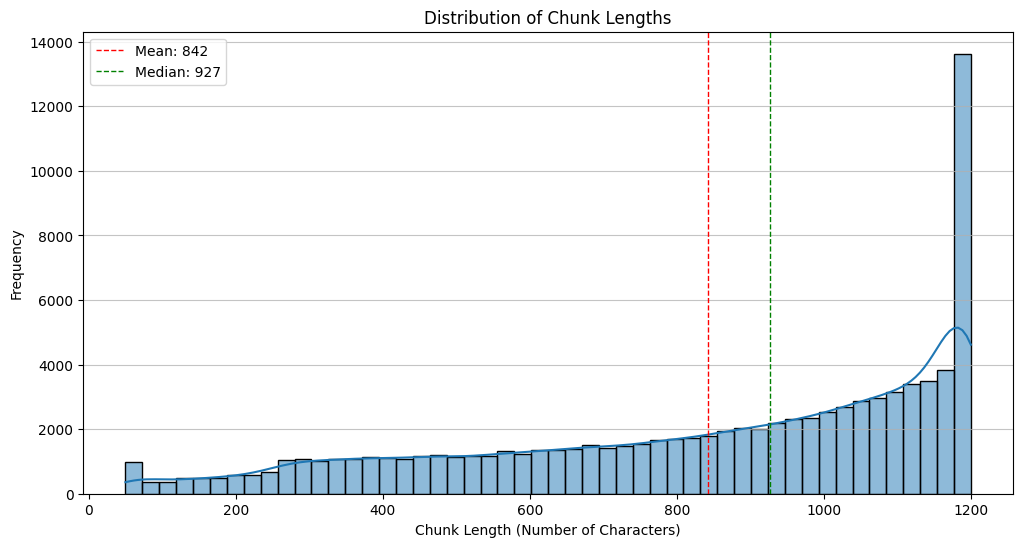


Sample of generated chunks (first 3 from the new list):
--- Chunk 1 ---
Content (first 100 chars): we will collect information, including personal informationand non-identifying information, when you...
Metadata: {'source': 'rag_legal/corpus/privacy_qa/Groupon.txt', 'filename': 'Groupon.txt', 'relative_path': 'corpus/privacy_qa/Groupon.txt', 'file_path': 'rag_legal/corpus/privacy_qa/Groupon.txt', 'chunk_number': 1, 'total_chunks_in_doc': 29}
--- Chunk 2 ---
Content (first 100 chars): commercial e-mails
you may choose not to receive commercial e-mails from us by following the instruc...
Metadata: {'source': 'rag_legal/corpus/privacy_qa/Groupon.txt', 'filename': 'Groupon.txt', 'relative_path': 'corpus/privacy_qa/Groupon.txt', 'file_path': 'rag_legal/corpus/privacy_qa/Groupon.txt', 'chunk_number': 2, 'total_chunks_in_doc': 29}
--- Chunk 3 ---
Content (first 100 chars): cookies and other technologies
you may manage how your browser handles cookiesby adjusting its priva...
Metadata: {'sour

In [16]:
document_chunks = create_document_chunks(
    processed_documents, 
    chunk_size=1200,
    chunk_overlap=250,
    min_chunk_char_length=50,
    verbose=False # set to True for more detailed o/p
)

# display a few chunks to verify
if document_chunks:
    print(f"\nSample of generated chunks (first 3 from the new list):")
    for i, chunk in enumerate(document_chunks[:3]):
        print(f"--- Chunk {i+1} ---")
        print(f"Content (first 100 chars): {chunk.page_content[:100].strip()}...")
        print(f"Metadata: {chunk.metadata}")
else:
    print("No chunks were generated by the new function.")

 ## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

 ### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

 #### **2.1.1** <font color=red> [2 marks] </font>

 Initialise an embedding function for loading the embeddings into the vector database.

 Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [17]:
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    print("OpenAI API Key not found in environment variables.")
    print("Please set the OPENAI_API_KEY environment variable for embedding and LLM functionalities.")
    # You might want to raise an error or use a fallback embedding model if no key is found.
    # For this assignment, we'll proceed, but embedding/LLM steps will fail.
else:
    print("OpenAI API Key found.")

OpenAI API Key found.


In [18]:
# initialise an embedding function
def get_openai_embeddings(api_key):
    """
    Initializes and returns an OpenAIEmbeddings object.
    Uses the "text-embedding-3-small" model by default.
    """
    if not api_key:
        print("Cannot initialize OpenAI embeddings without an API key.")
        return None
    
    try:
        embeddings_model = OpenAIEmbeddings(
            openai_api_key=api_key,
            model="text-embedding-3-small"  # Recommended for balance of performance and cost
        )
        print(f"OpenAIEmbeddings initialized successfully with model: {embeddings_model.model}")
        return embeddings_model
    except Exception as e:
        print(f"Error initializing OpenAIEmbeddings: {e}")
        return None

In [19]:
# initialize the embedding function
embeddings_function = get_openai_embeddings(openai_api_key)

OpenAIEmbeddings initialized successfully with model: text-embedding-3-small


 #### **2.1.2** <font color=red> [5 marks] </font>

 Load the embeddings to a vector database.

 Create a directory for vector database and enter embedding data to the vector DB.

In [20]:
import shutil
from pathlib import Path
from langchain_chroma import Chroma
from langchain.schema import Document  # optional, for type clarity

# updated function with load/create toggle
def create_or_load_chroma_db(chunks, 
                              embedding_func, 
                              db_path = "./rag_vector_db_chroma", 
                              load_existing = True):
    """
    loads existing Chroma vector db if available and load_existing=True.
    else deletes existing db (if any) and creates a new one using the provided chunks.
    """
    if not embedding_func:
        print("embedding function not provided.")
        return None

    db_exists = Path(db_path).exists()

    # if user wants to load existing db
    if db_exists and load_existing:
        print(f"loading existing vector db from: {db_path}")
        try:
            vector_db = Chroma(persist_directory=db_path, embedding_function=embedding_func)
            print("loaded existing vector db.")
            return vector_db
        except Exception as e:
            print(f"error loading vector db: {e}")
            return None

    # if user wants to recreate or no db exists
    if db_exists:
        print(f"deleting existing vector db at: {db_path}")
        try:
            shutil.rmtree(db_path)
            print("successfully deleted existing db.")
        except Exception as e:
            print(f"error deleting db: {e}")
            return None

    if not chunks:
        print("no chunks provided to create a new db.")
        return None

    print(f"creating new vector db at: {db_path}")
    try:
        vector_db = Chroma.from_documents(
            documents=chunks,
            embedding=embedding_func,
            persist_directory=db_path
        )
        vector_db.persist()
        print(f"created vector db with {len(chunks)} chunks.")
        return vector_db
    except Exception as e:
        print(f"error creating vector db: {e}")
        return None


In [ ]:
# True to load existing, False to delete and create new
use_existing_db = False

# define path for the persistent vector database
vector_db_directory = "./rag_vector_db_chroma"

# create or load the vector database
if document_chunks and embeddings_function:
    vector_database = create_or_load_chroma_db(
        chunks=document_chunks,
        embedding_func=embeddings_function,
        db_path=vector_db_directory,
        load_existing=use_existing_db
    )
else:
    print("skipping vector database creation due to missing chunks or embedding function.")
    vector_database = None

loading existing vector db from: ./rag_vector_db_chroma
loaded existing vector db.


 ### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

 #### **2.2.1** <font color=red> [5 marks] </font>

 Create a RAG chain.

In [22]:
from langchain.prompts import PromptTemplate

# create a RAG chain
def initialize_rag_chain(db, llm_api_key, k_retriever = 5, 
                         llm_model_name = "gpt-4.1-mini"):
    """
    Initializes a RetrievalQA chain using a Chroma vector database as a retriever
    and an OpenAI Chat model as the language model, with a custom prompt.
    """
    if not db:
        print("Vector database not provided. Cannot create RAG chain.")
        return None
    if not llm_api_key:
        print("OpenAI API key not provided for LLM. Cannot create RAG chain.")
        return None

    print("Initializing RAG chain...")
    
    try:
        # Use the passed llm_model_name or a default
        llm = ChatOpenAI(model_name=llm_model_name, openai_api_key=llm_api_key, temperature=0.1)
        print(f"LLM initialized with model: {llm.model_name}")
    except Exception as e:
        print(f"Error initializing LLM: {e}. Check API key and model name ('{llm_model_name}').")
        return None

    try:
        retriever = db.as_retriever(
            search_type="similarity",
            search_kwargs={'k': k_retriever} 
        )
        print(f"Retriever initialized with k={k_retriever} and search_type='similarity'")
    except Exception as e:
        print(f"Error initializing retriever: {e}")
        return None

    # Custom Prompt Template for Legal Documents
    prompt_template = """
    You are an AI assistant specialized in analyzing legal documents.
    Use the following pieces of context to answer the question at the end.
    If you don't know the answer from the context provided, just say that you don't know, do not try to make up an answer.
    If the answer is found, be concise and directly address the question based on the information in the context.
    Try to quote or refer to specific phrases from the context if they directly answer the question.

    Context:
    {context}

    Question: {question}

    Helpful Answer:
    """
    QA_CHAIN_PROMPT = PromptTemplate.from_template(prompt_template)

    try:
        rag_qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=True,
            chain_type_kwargs={"prompt": QA_CHAIN_PROMPT} # custom prompt
        )
        print("RAG chain (RetrievalQA) created successfully with custom prompt.")
        return rag_qa_chain
    except Exception as e:
        print(f"Error creating RAG chain: {e}")
        return None

# Initialize the RAG chain
if vector_database and openai_api_key:
    chosen_llm_model = "gpt-4.1-mini"
    print(f"Attempting to use LLM model: {chosen_llm_model}")
    
    rag_chain_instance = initialize_rag_chain(
        db=vector_database, 
        llm_api_key=openai_api_key, 
        k_retriever=3,
        llm_model_name=chosen_llm_model 
    )
else:
    print("Skipping RAG chain creation due to missing vector database or API key.")
    rag_chain_instance = None

Attempting to use LLM model: gpt-4.1-mini
Initializing RAG chain...
LLM initialized with model: gpt-4.1-mini
Retriever initialized with k=3 and search_type='similarity'
RAG chain (RetrievalQA) created successfully with custom prompt.


 #### **2.2.2** <font color=red> [3 marks] </font>

 Create a function to generate answer for asked questions.

 Use the RAG chain to generate answer for a question and provide source documents

In [23]:
# question answering
def get_answer_from_rag(chain, query):
    """
    Gets an answer and source documents for a given query using the RAG chain.
    """
    if not chain:
        print("RAG chain is not available. Cannot process query.")
        return None, None
    
    print(f"\nProcessing query: \"{query}\"")
    try:
        response = chain.invoke({"query": query}) 
        
        answer = response.get("result", "No answer generated.")
        source_documents = response.get("source_documents", [])
        
        print(f"\nGenerated Answer:\n{answer}")
        
        if source_documents:
            print(f"\nSource Documents ({len(source_documents)} retrieved):")
            for i, doc_source in enumerate(source_documents):
                print(f"  --- Source {i+1} ---")
                # Use the 'filename' key that Langchain natively carries
                print(f"  Filename: {doc_source.metadata.get('filename', 'N/A')}")
                # Use 'relative_path' for directory information
                print(f"  Directory: {doc_source.metadata.get('relative_path', 'N/A')}")
                print(f"  Chunk Num: {doc_source.metadata.get('chunk_number', 'N/A')}")

        else:
            print("  No source documents were returned.")
            
        return answer, source_documents
    except Exception as e:
        print(f"Error during RAG chain invocation for query '{query}': {e}")
        return f"Error processing query: {e}", []



In [24]:
# example query
if rag_chain_instance:
    example_query = "What does an NDA usually entail?"
    generated_answer, source_docs = get_answer_from_rag(rag_chain_instance, example_query)
else:
    print("RAG chain not initialized. Cannot run example query.")


Processing query: "What does an NDA usually entail?"

Generated Answer:
An NDA (Non-Disclosure Agreement) usually entails that the parties agree to keep certain non-public, confidential, or proprietary information shared between them confidential. For example, in the provided context, the NDA is entered into "in connection with the consideration of a possible investment or financing transaction (the 'purpose')," where the recipient "desires to receive certain information from the disclosing party that is non-public, confidential, or proprietary in nature." The agreement binds the parties to "all of the protective terms and conditions of the NDA" during the term and for a specified period thereafter (e.g., five years).

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Standard_20NDA_20by_20Axial.txt
  Directory: corpus/contractnli/Standard_20NDA_20by_20Axial.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: NDA-M5-Systems.txt
  Directory: corpus/contractnli/NDA-M5-Systems

 ## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

 ### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

 #### **3.1.1** <font color=red> [2 marks] </font>

 Extract all the questions and all the answers/ground truths from the benchmark files.

 Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [25]:
# create question set from all the questions from the benchmark data
# create ground truth/answer set
def load_benchmark_qna(benchmark_dir_path = "benchmark"):
    """
    loads questions and their corresponding ground truth answers from JSON benchmark files.
    each question can have multiple ground truth snippets/answers.
    returns:
        - list of questions (queries).
        - list of lists of ground truth answers (one list of answers per question).
    """
    benchmark_path = Path(benchmark_dir_path)
    all_queries = []
    all_ground_truth_sets = [] # list of lists, as one query can have multiple GT answers

    benchmark_files = ["contractnli.json", "cuad.json", "maud.json", "privacy_qa.json"]
    
    print(f"Loading benchmark data from: {benchmark_path}")

    for file_name in benchmark_files:
        file_path = benchmark_path / file_name
        if not file_path.exists():
            print(f"Benchmark file not found: {file_path}. Skipping.")
            continue
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            num_tests_in_file = 0
            for test_case in data.get("tests", []):
                query = test_case.get("query")
                snippets = test_case.get("snippets", [])
                
                current_ground_truths = [s.get("answer", "").strip() for s in snippets if s.get("answer", "").strip()]
                
                if query and current_ground_truths: # Only add if query and some GT answers exist
                    all_queries.append(query)
                    all_ground_truth_sets.append(current_ground_truths)
                    num_tests_in_file += 1
            print(f"Loaded {num_tests_in_file} valid Q&A pairs from {file_name}.")
        except json.JSONDecodeError:
            print(f"Error decoding JSON from {file_path}. Skipping.")
        except Exception as e:
            print(f"An unexpected error occurred with {file_path}: {e}. Skipping.")
            
    print(f"\nTotal questions loaded for evaluation: {len(all_queries)}")
    print(f"Total sets of ground truth answers loaded: {len(all_ground_truth_sets)}")
    
    return all_queries, all_ground_truth_sets


In [26]:
# load benchmark data
benchmark_data_directory = "./rag_legal/benchmarks" # Adjust if your folder is named differently
evaluation_questions, evaluation_ground_truths = load_benchmark_qna(benchmark_data_directory)

# verify loaded data
if evaluation_questions and evaluation_ground_truths:
    print(f"\nSample benchmark data (first Q&A):")
    print(f"Question 1: {evaluation_questions[0]}")
    print(f"Ground Truths for Q1: {evaluation_ground_truths[0]}")
else:
    print("No benchmark data loaded. Evaluation cannot proceed.")

Loading benchmark data from: rag_legal/benchmarks
Loaded 977 valid Q&A pairs from contractnli.json.
Loaded 4042 valid Q&A pairs from cuad.json.
Loaded 1676 valid Q&A pairs from maud.json.
Loaded 194 valid Q&A pairs from privacy_qa.json.

Total questions loaded for evaluation: 6889
Total sets of ground truth answers loaded: 6889

Sample benchmark data (first Q&A):
Question 1: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?
Ground Truths for Q1: ['Any and all proprietary rights, including but not limited to rights to and in inventions, patent rights, utility models, copyrights, trademarks and trade secrets, in and to any Confidential Information shall be and remain with the Participants respectively, and Mentor shall not have any right, license, title or interest in or to any Confidential Information, except the limited right to review, assess

 #### **3.1.2** <font color=red> [5 marks] </font>

 Create a function to evaluate the generated answers.

 Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

 (Note: RAGAS setup is more involved and typically requires the context retrieved by RAG, so we'll focus on ROUGE and BLEU as per the simpler setup in the user's original code).

In [27]:
# evaluate the RAG pipeline
def calculate_evaluation_scores(generated_answers, 
                                ground_truth_sets):
    """
    calculates ROUGE and BLEU scores for generated answers against ground truth sets.
    for ROUGE, it compares the generated answer against a concatenated string of all ground truths for that question.
    for BLEU, it compares the generated answer against the list of individual ground truth answers.
    """
    if not generated_answers or not ground_truth_sets or len(generated_answers) != len(ground_truth_sets):
        print("Mismatch in lengths of generated answers and ground truth sets for ROUGE/BLEU, or lists are empty.")
        return {"rouge1_f1": 0, "rouge2_f1": 0, "rougeL_f1": 0, "bleu": 0}

    rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
    rouge_calc = rouge_scorer.RougeScorer(rouge_metrics, use_stemmer=True)
    
    bleu_calc = None # Initialize
    try:
        bleu_calc = hf_evaluate.load('bleu') # <<< USE ALIASED hf_evaluate
        print("BLEU metric loaded successfully from Hugging Face evaluate.")
    except Exception as e:
        print(f"Could not load BLEU metric from Hugging Face evaluate: {e}. BLEU scores will be 0.")
        # bleu_calc remains None

    all_rouge_f1 = {metric: [] for metric in rouge_metrics}
    all_bleu = []

    print(f"Calculating ROUGE and BLEU scores for {len(generated_answers)} responses...")
    for gen_ans, gt_list in tqdm(zip(generated_answers, ground_truth_sets), total=len(generated_answers), desc="Evaluating ROUGE/BLEU"):
        
        current_gen_ans = str(gen_ans) if gen_ans is not None else ""
        
        # For ROUGE
        current_gt_list_for_rouge = [str(g) for g in gt_list if g is not None] if gt_list else [""]
        concatenated_gt = " ".join(current_gt_list_for_rouge)
        
        if not gt_list: # If no ground truths for this question, effectively
            for metric in rouge_metrics: all_rouge_f1[metric].append(0)
            if bleu_calc: all_bleu.append(0)
            continue
        
        try:
            rouge_scores = rouge_calc.score(concatenated_gt, current_gen_ans)
            for metric in rouge_metrics:
                all_rouge_f1[metric].append(rouge_scores[metric].fmeasure)
        except Exception as e:
            print(f"Error calculating ROUGE for a response: {e}")
            for metric in rouge_metrics: all_rouge_f1[metric].append(0)
            
        # For BLEU
        if bleu_calc:
            try:
                # BLEU expects a list of reference strings for each prediction
                current_gt_list_for_bleu = [[str(g) for g in gt_list if g is not None]] if any(g is not None for g in gt_list) else [[""]]
                predictions_for_bleu = [current_gen_ans]
                
                bleu_result = bleu_calc.compute(predictions=predictions_for_bleu, references=current_gt_list_for_bleu)
                all_bleu.append(bleu_result['bleu'])
            except Exception as e:
                print(f"Error calculating BLEU for a response: {e}")
                all_bleu.append(0)
        else:
            all_bleu.append(0) # If bleu_calc is None

    avg_scores = {}
    for metric in rouge_metrics:
        avg_scores[f"{metric}_f1"] = np.mean(all_rouge_f1[metric]) if all_rouge_f1[metric] else 0
    
    avg_scores["bleu"] = np.mean(all_bleu) if all_bleu else 0

    print("\n--- Evaluation Metrics Summary (ROUGE/BLEU) ---")
    for metric_name, score_val in avg_scores.items():
        print(f"  Average {metric_name.replace('_f1', ' F1').upper()}: {score_val:.4f}")
    print("----------------------------------")
    
    return avg_scores


 #### **3.1.3** <font color=red> [3 marks] </font>

 Draw inferences by evaluating answers to all questions.

 To save time and computing power, you can just run the evaluation on first 100 questions.

In [28]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness 
)
from datasets import Dataset
import pandas as pd


def perform_full_evaluation(rag_pipeline,
                            questions_list,
                            ground_truth_answers_list,
                            max_questions_to_eval = 100,
                            ragas_llm = None, 
                            ragas_embeddings = None
                           ):
    """
    Runs the full evaluation pipeline: ROUGE, BLEU, and RAGAS.
    """
    if not rag_pipeline:
        print("RAG pipeline is not initialized. Cannot perform evaluation.")
        return None, None
    if not questions_list: # check if the list itself is None or empty
        print("Evaluation questions are missing or empty.")
        return None, None
    if not ground_truth_answers_list: # check if the list itself is None or empty
        print("Evaluation ground truths are missing or empty.")
        return None, None
    
    num_available_questions = len(questions_list)
    actual_eval_count = min(max_questions_to_eval, num_available_questions)

    if actual_eval_count == 0:
        print("No questions available for evaluation after limiting (actual_eval_count is 0).")
        return None, None

    print(f"Starting full evaluation for {actual_eval_count} questions (out of {num_available_questions} available).")

    current_eval_questions = questions_list[:actual_eval_count]
    current_eval_ground_truths_lists = ground_truth_answers_list[:actual_eval_count]

    generated_answers_for_eval = []
    ragas_eval_data = {"question": [], "answer": [], "contexts": [], "ground_truth": []}

    print("Generating RAG answers and preparing data for all evaluations...")
    for i, query_text in enumerate(tqdm(current_eval_questions, desc="Generating RAG answers")):
        ans_text, source_docs = get_answer_from_rag(rag_pipeline, query_text)
        
        generated_ans = str(ans_text) if ans_text is not None else ""
        generated_answers_for_eval.append(generated_ans)

        ragas_eval_data["question"].append(str(query_text))
        ragas_eval_data["answer"].append(generated_ans)
        contexts = [str(doc.page_content) for doc in source_docs] if source_docs else []
        ragas_eval_data["contexts"].append(contexts)
        gt_for_ragas = str(current_eval_ground_truths_lists[i][0]) if current_eval_ground_truths_lists[i] and current_eval_ground_truths_lists[i][0] is not None else ""
        ragas_eval_data["ground_truth"].append(gt_for_ragas)

        if i < 3: # print samples
            print(f"\n--- Eval Sample Q&A ({i+1}/{actual_eval_count}) ---")
            print(f"  Question: {query_text}")
            print(f"  Generated Answer: {generated_ans}")
            print(f"  Retrieved Contexts (first 50 chars each): {[c[:50]+'...' for c in contexts]}")
            print(f"  Ground Truths (original list): {current_eval_ground_truths_lists[i]}")
            print(f"  Ground Truth (for RAGAS): {gt_for_ragas}")
            print("---------------------------------------\n")

    # calculate ROUGE and BLEU scores using the dedicated function
    print("\nCalculating ROUGE and BLEU scores...")
    rouge_bleu_scores = calculate_evaluation_scores(generated_answers_for_eval, current_eval_ground_truths_lists)

    # Calculate RAGAS scores
    ragas_scores_dict = None
    if ragas_llm: # Proceed only if RAGAS LLM is available
        print("\nCalculating RAGAS scores...")
        try:
            ragas_dataset = Dataset.from_dict(ragas_eval_data)
            metrics_to_evaluate = [faithfulness, answer_relevancy, context_precision, context_recall, answer_correctness]
            
            results = ragas_evaluate(
                dataset=ragas_dataset,
                metrics=metrics_to_evaluate,
                llm=ragas_llm,
                embeddings=ragas_embeddings
            )
            ragas_scores_dict = results 
            print("\n--- RAGAS Metrics Summary ---")
            print(ragas_scores_dict) # print the raw result object/dictionary
            print("-----------------------------")
        except Exception as e:
            print(f"Error during RAGAS evaluation: {e}")
            ragas_scores_dict = {"error": str(e)} # store error info
    else:
        print("Skipping RAGAS evaluation as RAGAS LLM was not provided (e.g., API key issue or failed init).")
        ragas_scores_dict = {"status": "skipped_no_llm"}

    return rouge_bleu_scores, ragas_scores_dict

In [29]:
openai_api_key = os.getenv("OPENAI_API_KEY")

ragas_eval_llm_model_name = "gpt-4.1-mini"
ragas_eval_llm = None
ragas_eval_embeddings = None

if openai_api_key:
    try:
        ragas_eval_llm = ChatOpenAI(model_name=ragas_eval_llm_model_name, openai_api_key=openai_api_key, temperature=0)
        ragas_eval_embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key, model="text-embedding-3-small")
        print(f"RAGAS LLM ({ragas_eval_llm_model_name}) and Embeddings initialized.")
    except Exception as e:
        print(f"Error initializing RAGAS LLM/Embeddings: {e}. RAGAS will be skipped.")
        ragas_eval_llm = None 
else:
    print("CRITICAL: OpenAI API Key not found. RAGAS evaluation will be skipped.")

NUM_QUESTIONS_FOR_OVERALL_EVAL = 100 # adjust as needed

# check readiness for final evaluation
ready_for_final_eval = True
final_rouge_bleu_metrics = None
final_ragas_result_object = None

try:

    if not rag_chain_instance: ready_for_final_eval = False; print("Skipping: `rag_chain_instance` not available.")
    if not evaluation_questions: ready_for_final_eval = False; print("Skipping: `evaluation_questions` not available.")
    if not evaluation_ground_truths: ready_for_final_eval = False; print("Skipping: `evaluation_ground_truths` not available.")
except NameError as e:
    print(f"Skipping final evaluation: A key variable ('{e.name}') was not defined. Please run all prerequisite cells.")
    ready_for_final_eval = False

if not ragas_eval_llm: 
    print("Note: RAGAS part of the evaluation will be skipped as its LLM is not available.")

# perform Evaluation ---
if ready_for_final_eval:
    print(f"\nInitiating RAG pipeline evaluation on up to {NUM_QUESTIONS_FOR_OVERALL_EVAL} question(s).")
    
    final_rouge_bleu_metrics, final_ragas_result_object = perform_full_evaluation(
        rag_pipeline=rag_chain_instance,
        questions_list=evaluation_questions,
        ground_truth_answers_list=evaluation_ground_truths,
        max_questions_to_eval=NUM_QUESTIONS_FOR_OVERALL_EVAL,
        ragas_llm=ragas_eval_llm, 
        ragas_embeddings=ragas_eval_embeddings
    )

    # print ROUGE/BLEU Results ---
    if final_rouge_bleu_metrics:
        print("\n" + "="*60)
        print("OVERALL RAG PIPELINE - ROUGE/BLEU SUMMARY")
        print("="*60)
        actual_eval_count_display = min(NUM_QUESTIONS_FOR_OVERALL_EVAL, len(evaluation_questions) if evaluation_questions else 0)
        print(f"Evaluated on: {actual_eval_count_display} questions")
        for metric_name, score_value in final_rouge_bleu_metrics.items():
            print(f"  Average {metric_name.replace('_f1', ' F1').upper()}: {score_value:.4f}")
        print("="*60)
        
    # print RAGAS Results ---
    if final_ragas_result_object:
        actual_eval_count_display = min(NUM_QUESTIONS_FOR_OVERALL_EVAL, len(evaluation_questions) if evaluation_questions else 0)
        if isinstance(final_ragas_result_object, dict) and "error" in final_ragas_result_object:
            print("\n" + "="*60)
            print("RAGAS EVALUATION ERROR")
            print(f"Error details: {final_ragas_result_object['error']}")
            print("="*60)
        elif isinstance(final_ragas_result_object, dict) and "status" in final_ragas_result_object and final_ragas_result_object["status"] == "skipped_no_llm":
            print("\n" + "="*60)
            print("RAGAS EVALUATION SKIPPED (No LLM or API Key issue for RAGAS)")
            print("="*60)
        # Check if it's the RAGAS EvaluationResult object or a dict of scores
        elif hasattr(final_ragas_result_object, 'scores') or isinstance(final_ragas_result_object, dict):
            print("\n" + "="*60)
            print("OVERALL RAG PIPELINE - RAGAS SUMMARY")
            print("="*60)
            print(f"Evaluated on: {actual_eval_count_display} questions")
            
            scores_to_print = {}
            if hasattr(final_ragas_result_object, 'to_dict'): 
                 scores_to_print = final_ragas_result_object.to_dict()
            elif isinstance(final_ragas_result_object, dict): 
                 scores_to_print = final_ragas_result_object

            if scores_to_print:
                for metric_name, score_value in scores_to_print.items():
                    if isinstance(score_value, (float, np.floating, int)):
                        print(f"  Average {metric_name.replace('_', ' ').title()}: {score_value:.4f}")
            else:
                print("  RAGAS scores object could not be parsed into a printable dictionary.")
                print(f"  Raw RAGAS result: {final_ragas_result_object}")
            print("="*60)
        else:
            print("\n" + "="*60)
            print("RAGAS EVALUATION - UNKNOWN RESULT FORMAT")
            print(f"Raw RAGAS result: {final_ragas_result_object}")
            print("="*60)
else:
    print("\nFinal evaluation was not performed. Check logs above for reasons (e.g., missing variables, API key).")

RAGAS LLM (gpt-4.1-mini) and Embeddings initialized.

Initiating RAG pipeline evaluation on up to 100 question(s).
Starting full evaluation for 100 questions (out of 6889 available).
Generating RAG answers and preparing data for all evaluations...


Generating RAG answers:   0%|          | 0/100 [00:00<?, ?it/s]


Processing query: "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"


Generating RAG answers:   1%|          | 1/100 [00:02<04:22,  2.65s/it]


Generated Answer:
Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. It states, "the information, relating to the other party, shall remain the property of such other party (as disclosing party) and its disclosure shall not confer on the other party (as receiving party) any rights. no license is hereby granted by either party to the other party, directly or indirectly, under any patent, trademark, trade secret or other intellectual property."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Directory: corpus/contractnli/ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Chunk Num: 5
  --- Source 2 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: NDA-M5-Systems.txt
  Directory: corpus/contractnli/NDA-M5-Systems.txt
  Chunk N

Generating RAG answers:   2%|▏         | 2/100 [00:05<04:41,  2.88s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. It defines "confidential information" broadly to include "technical, scientific, economic and business data, business plans, and the like," and explicitly includes information disclosed "orally, visually, in writing or in any other tangible form," not limited to technical information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FLOTEKINDUSTRIESINCCN_05_09_2019-EX-10.1-SUPPLY AGREEMENT.txt
  Directory: corpus/cuad/FLOTEKINDUSTRIESINCCN_05_09_2019-EX-10.1-SUPPLY AGREEMENT.txt
  Chunk Num: 9
  --- Source 2 ---
  Filename: lti-two-way-cda-template.txt
  Directory: corpus/contractnli/lti-two-way-cda-template.txt
  Chunk Num: 2
  --- Source 3 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38

--- Eval Sample Q&A (2/100) 

Generating RAG answers:   3%|▎         | 3/100 [00:07<03:57,  2.45s/it]


Generated Answer:
Yes, the document states that "no termination of this agreement shall affect the obligations of the parties contained in the confidentiality agreement, all of which obligations shall survive termination of this agreement." Additionally, it specifies that certain provisions, including confidentiality, "shall survive the expiration of the agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement.txt
  Chunk Num: 235
  --- Source 2 ---
  Filename: FLIR Systems, Inc._Teledyne Technologies Incorporated.txt
  Directory: corpus/maud/FLIR Systems, Inc._Teledyne Technologies Incorporated.txt
  Chunk Num: 405
  --- Source 3 ---
  Filename: National General Holdings Corp._The Allstate Corporation.txt
  Directory: corpus/maud/National General Holdings Corp._The Allstate Corporation.t

Generating RAG answers:   4%|▍         | 4/100 [00:11<04:39,  2.91s/it]


Generated Answer:
Yes, the document permits the Receiving Party to retain some Confidential Information even after its return or destruction. Specifically, section 10.6 states that the Receiving Party "may retain a reasonable number of archival copies as may be required by law or its reasonable standard document retention policies."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: WaterNowInc_20191120_10-Q_EX-10.12_11900227_EX-10.12_Distributor Agreement.txt
  Directory: corpus/cuad/WaterNowInc_20191120_10-Q_EX-10.12_11900227_EX-10.12_Distributor Agreement.txt
  Chunk Num: 44
  --- Source 2 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154
  --- Source 3 ---
  Filename: ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Directory: corpus/contractnli/ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Chunk Num: 5

Processin

Generating RAG answers:   5%|▌         | 5/100 [00:17<06:48,  4.30s/it]


Generated Answer:
Yes, the agreement allows the Receiving Party to share some Confidential Information with third parties, including consultants, agents, and professional advisors, but under strict conditions. Specifically:

- Paragraph 4 permits disclosure to "employees, directors, officers, advisors, attorneys, auditors and agents only on a need-to-know basis in connection with the opportunity," and requires that these parties "treat such confidential information in a manner consistent with this agreement."

- Paragraph 10.3(a) allows disclosure of the terms of the agreement to "advisors (including financial advisors, attorneys and accountants), actual or potential acquisition partners or private investors, and others on a need to know basis," provided such disclosures are made "under appropriate confidentiality provisions substantially equivalent to those in this agreement."

- Paragraph 12.2 states that information "may be disclosed to employees, agents or consultants of the recei

Generating RAG answers:   6%|▌         | 6/100 [00:21<06:18,  4.03s/it]


Generated Answer:
Yes, the document requires the Receiving Party to notify the Disclosing Party if they are required by law, regulation, or judicial process to disclose any Confidential Information. Specifically, it states the Receiving Party shall "give disclosing party reasonable notice of such required disclosure prior to disclosure" and "provide the disclosing party with prompt written notice of such requirement so that the disclosing party may seek a protective order or other appropriate relief."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 2 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81
  --- Source 3 ---
  Filename: SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  Directory: corpus/contractnli/SE_NDCA_

Generating RAG answers:   7%|▋         | 7/100 [00:24<05:47,  3.74s/it]


Generated Answer:
Yes, the document allows the Receiving Party to acquire information similar to the Confidential Information from a third party, as long as the third party has the right to make such a disclosure. This is stated in the clause: "confidential information shall not include... (c) subsequently disclosed to the receiving party by a third party having the right to make such a disclosure."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: MutualNDA_The_Knights_of_Unity.txt
  Directory: corpus/contractnli/MutualNDA_The_Knights_of_Unity.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  Directory: corpus/contractnli/SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  Chunk Num: 6
  --- Source 3 ---
  Filename: Microgenics Corporation - Collaborative Development and Commercialization Agreement.txt
  Directory: corpus/cuad/Microgenics Corporation - Collaborative Development and Commercialization Agreement.txt
  Chunk Num: 155


Generating RAG answers:   8%|▊         | 8/100 [00:27<05:13,  3.40s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share Confidential Information with their employees, but only on a need-to-know basis and in connection with the opportunity. Specifically, paragraph 4 states that "confidential information may be disclosed by the receiving party to its employees... only on a need-to-know basis in connection with the opportunity," and each such employee "shall treat such confidential information in a manner consistent with this agreement." Additionally, employees must agree to hold the information in confidence and not use it for any unauthorized purpose before receiving any confidential information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: MutualNDA_The_Knights_of_Unity.txt
  Directory: corpus/contractnli/MutualNDA_The_Knights_of_Unity.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: Microgenics Corporation - Collaborative Development and Commercialization Agreement.txt
  Directory: corpus/cuad/Microgenics Corpo

Generating RAG answers:   9%|▉         | 9/100 [00:29<04:39,  3.07s/it]


Generated Answer:
Yes, the document restricts the use of Confidential Information to the purposes stated in the Agreement. For example, it states that "the recipient agrees not to use the confidential information for any purpose other than that set forth in section 1 of this agreement," and that confidential information "shall not be used for any purpose other than to analyze, implement or complete the transactions."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: RitterPharmaceuticalsInc_20200313_S-4A_EX-10.54_12055220_EX-10.54_Development Agreement.txt
  Directory: corpus/cuad/RitterPharmaceuticalsInc_20200313_S-4A_EX-10.54_12055220_EX-10.54_Development Agreement.txt
  Chunk Num: 108
  --- Source 2 ---
  Filename: NDA-M5-Systems.txt
  Directory: corpus/contractnli/NDA-M5-Systems.txt
  Chunk Num: 4
  --- Source 3 ---
  Filename: SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  Directory: corpus/contractnli/SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  Chunk Num: 6

Proce

Generating RAG answers:  10%|█         | 10/100 [00:33<05:03,  3.37s/it]


Generated Answer:
Yes, the agreement explicitly states that "the information, relating to the other party, shall remain the property of such other party (as disclosing party) and its disclosure shall not confer on the other party (as receiving party) any rights." This means the Agreement does not grant the Receiving Party any rights to the Confidential Information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Directory: corpus/contractnli/ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Chunk Num: 5

Processing query: "Consider DBT's Mutual Non-Disclosure Agreement; Does the document include a clause that prevents the Receiving Party fro

Generating RAG answers:  11%|█         | 11/100 [00:36<04:49,  3.26s/it]


Generated Answer:
Yes, the agreement includes a clause that prevents the parties from disclosing the terms of the agreement, which would include the fact that the agreement was agreed upon or negotiated. Specifically, clause 7.4 states: "the parties hereto agree to keep the terms of this agreement confidential and not to divulge any part thereof to any third party except" under limited exceptions. This confidentiality obligation covers the existence and terms of the agreement itself.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: VERTICALNETINC_04_01_2002-EX-10.19-MAINTENANCE AND SUPPORT AGREEMENT.txt
  Directory: corpus/cuad/VERTICALNETINC_04_01_2002-EX-10.19-MAINTENANCE AND SUPPORT AGREEMENT.txt
  Chunk Num: 61
  --- Source 3 ---
  Filename: ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Directory: corpus/contractnli/ADVANIDE-NON-DISCLOSURE-AGREEMENT.

Generating RAG answers:  12%|█▏        | 12/100 [00:39<04:36,  3.14s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. It explicitly defines "confidential information" to include a broad range of information such as "technical, scientific, economic and business data, business plans," as well as "records, files, analysis, documents, software, computer or electronic data disks or tapes, test data, printouts, processes, designs," and "technical, financial, business plan and customer information," among others.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38
  --- Source 3 ---
  Filename: NDA-Seeed.txt
  Directory: corpus/contractnli/NDA-Seeed.txt
  Chunk Num: 3

Processing query: "Co

Generating RAG answers:  13%|█▎        | 13/100 [00:42<04:31,  3.12s/it]


Generated Answer:
The provided context does not state that all Confidential Information must be expressly identified by the Disclosing Party. It focuses on obligations regarding nondisclosure, use, and handling of confidential information, as well as procedures for legally required disclosures, but does not mention a requirement that the Disclosing Party expressly identify all Confidential Information. Therefore, based on the context given, the document does not require that all Confidential Information be expressly identified by the Disclosing Party.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 2 ---
  Filename: VERTICALNETINC_04_01_2002-EX-10.19-MAINTENANCE AND SUPPORT AGREEMENT.txt
  Directory: corpus/cuad/VERTICALNETINC_04_01_2002-EX-10.19-MAINTENANCE AND SUPPORT AGREEMENT.txt
  Chunk Num: 57
  --

Generating RAG answers:  14%|█▍        | 14/100 [00:45<04:27,  3.11s/it]


Generated Answer:
Yes, the agreement allows the Receiving Party to independently develop information similar to the Confidential Information. Specifically, clause 4 states that "the terms of this agreement shall not be construed to limit either party's right to develop independently or acquire products without use of the other party's confidential information," and that "nothing in this agreement will prohibit the recipient from developing or having developed for it products, concepts, systems or techniques that are similar to or compete with the products, concepts, systems or techniques contemplated by or embodied in the confidential information provided that the recipient does not violate any of its obligations under this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ON2TECHNOLOGIES,INC_11_17_2006-EX-10.3-SUPPORT AND MAINTENANCE AGREEMENT.txt
  Directory: corpus/cuad/ON2TECHNOLOGIES,INC_11_17_2006-EX-10.3-SUPPORT AND MAINTENANCE AGREEMENT.txt
  Chunk Nu

Generating RAG answers:  15%|█▌        | 15/100 [00:48<04:22,  3.08s/it]


Generated Answer:
Yes, the document permits the Receiving Party to retain some Confidential Information even after its return or destruction. Specifically, section 10.6 states that "the receiving party may retain a reasonable number of archival copies as may be required by law or its reasonable standard document retention policies."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: WaterNowInc_20191120_10-Q_EX-10.12_11900227_EX-10.12_Distributor Agreement.txt
  Directory: corpus/cuad/WaterNowInc_20191120_10-Q_EX-10.12_11900227_EX-10.12_Distributor Agreement.txt
  Chunk Num: 44
  --- Source 2 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154
  --- Source 3 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 6

Processing query: "Consider DBT's Mutua

Generating RAG answers:  16%|█▌        | 16/100 [00:50<03:55,  2.80s/it]


Generated Answer:
Yes, the agreement requires the Receiving Party to notify the Disclosing Party if legally required to disclose any Confidential Information. Specifically, it states that the Receiving Party shall "(i) give disclosing party reasonable notice of such required disclosure prior to disclosure" and "give, to the extent and as soon as legally permissible, prior notice of such disclosure to the other party."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 3 ---
  Filename: NDA-SqillerBetaTesters.txt
  Directory: corpus/contractnli/NDA-SqillerBetaTesters.txt
  Chunk Num: 7

Processing query: "Consider DBT's Mutual Non-Disclosure Agreement; Does the document allow the Receiv

Generating RAG answers:  17%|█▋        | 17/100 [00:52<03:31,  2.55s/it]


Generated Answer:
Yes, the document allows the Receiving Party to acquire information similar to the Confidential Information from a third party, provided that such information "was received from a third party not under an obligation of confidence to receiving party," as stated in section 3(b).

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: ASIANDRAGONGROUPINC_08_11_2005-EX-10.5-Reseller Agreement.txt
  Directory: corpus/cuad/ASIANDRAGONGROUPINC_08_11_2005-EX-10.5-Reseller Agreement.txt
  Chunk Num: 35
  --- Source 3 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81

Processing query: "Consider DBT's Mutual Non-Disclosure Agreement; Does the document allow the Receiving Party to share some Confidenti

Generating RAG answers:  18%|█▊        | 18/100 [00:55<03:37,  2.65s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share Confidential Information with their employees, but only "to the extent that such employees have a specific need to know of the confidential information, for the evaluation of the proposed transaction." Additionally, those employees must have read the non-disclosure agreement and agreed to abide by its terms before receiving any confidential information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 5

Processing query: "Consider DBT's Mutual Non-Disclosure Agreement; Does the document restrict the use of Conf

Generating RAG answers:  19%|█▉        | 19/100 [00:59<03:56,  2.92s/it]


Generated Answer:
Yes, the document restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, section 9.2 states that "each party agrees not to use the confidential information of the other party for any purpose, including trading in the financial instruments of the other party, except in its performance under this agreement." Additionally, section 3 reinforces this by stating that the parties "agree not to use the confidential information disclosed to it by the other party for its own use or for any purpose except to carry out discussions concerning and the undertaking of any business relationship between the two."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Directory: corpus/cuad/Apollo Endosurgery - Manufacturing and Supply Agreement.txt

Generating RAG answers:  20%|██        | 20/100 [01:02<03:53,  2.92s/it]


Generated Answer:
Yes, the document specifies that upon termination of the Agreement, the Receiving Party is required to either return or destroy the Confidential Information. For example, it states: "upon termination of this agreement, the receiving party shall promptly return, or upon request of the disclosing party destroy and provide written certification of such destruction, all of the disclosing party's confidential information" and also allows the Receiving Party to retain a reasonable number of archival copies as required by law or document retention policies. Additionally, the Receiving Party may keep one copy for purposes such as addressing claims, legal compliance, or archival purposes, but must otherwise comply with the return or destruction obligations.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_E

Generating RAG answers:  21%|██        | 21/100 [01:04<03:44,  2.84s/it]


Generated Answer:
Yes, the document clearly indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. It states that "any confidential information shall remain the property of the disclosing party" and that the Agreement "shall not be construed as granting or conferring to the receiving party, either expressly or by implication, any license or proprietary interest in or to any confidential information nor any right of use beyond the purpose of this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 30
  --- Source 2 ---
  Filename: QEP-Williston-Form-of-Confidentiality-Agreement-BMO.txt
  Directory: corpus/contractnli/QEP-Williston-Form-of-Confidentiality-Agreement-BMO.txt
  Chunk Num: 17
  --- Source 3 ---
  Filename: AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_Maintenance Agreement1.txt
  Di

Generating RAG answers:  22%|██▏       | 22/100 [01:08<03:56,  3.04s/it]


Generated Answer:
Yes, the document mentions that some obligations of the Agreement may survive termination. Specifically, it states "the provisions of this section 10.4 shall survive the termination of this agreement," and section 10.8 notes that "the provisions of sections 3.6, 4, 6, 8, 9 and 11 shall survive any termination of this agreement." Additionally, section 8.9 states that "expiration or termination of the agreement shall not relieve the parties of any obligation accruing before such expiration or termination," and lists several sections whose provisions "shall survive the expiration of the agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SimplicityEsportsGamingCompany_20181130_8-K_EX-10.1_11444071_EX-10.1_Franchise Agreement.txt
  Directory: corpus/cuad/SimplicityEsportsGamingCompany_20181130_8-K_EX-10.1_11444071_EX-10.1_Franchise Agreement.txt
  Chunk Num: 33
  --- Source 2 ---
  Filename: CARDAX,INC_08_19_2014-EX-10.1-COLLABORATION AGREEMENT.tx

Generating RAG answers:  23%|██▎       | 23/100 [01:11<03:57,  3.08s/it]


Generated Answer:
Yes, the document permits the Receiving Party to retain some Confidential Information even after its return or destruction. Specifically, it states that the Receiving Party "may retain a reasonable number of archival copies as may be required by law or its reasonable standard document retention policies" (section 10.6) and "may keep copies of all confidential information within its ordinary legal archives (including its back-up systems)" (section 11.5). Additionally, under section 4.09, the Receiving Party may retain documents and materials "to the extent such documents and materials are identified as necessary for beneficial use of a further project or a license granted herein" provided it notifies the Disclosing Party in writing.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion 

Generating RAG answers:  24%|██▍       | 24/100 [01:14<03:53,  3.07s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share Confidential Information with third parties such as "advisors, affiliates, agents, assigns, attorneys, employees, directors, officers and or members ('agents')" but only "with a need-to-know the confidential information for the purposes of analyzing, implementing or completing the transactions." The Receiving Party must also "require all recipients of the confidential information to be bound by the terms of this agreement" and is responsible for any breach by these agents.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 30
  --- Source 2 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 1
  --- Source 3 ---
  Filename: SE_NDCA_and_PRE-QUAL_PACKAGE_March-2016.txt
  Directory: corpus/contractnli/SE_N

Generating RAG answers:  25%|██▌       | 25/100 [01:16<03:28,  2.79s/it]


Generated Answer:
The provided context does not explicitly address whether the Receiving Party is permitted to create a copy of some Confidential Information under certain circumstances. Therefore, based on the information given, I do not know if the agreement permits copying of Confidential Information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 30
  --- Source 2 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 1
  --- Source 3 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 31

Processing query: "Consider the Data Use Agreement in New York City; Does the document allow the Receiving Party to share some Confidential Information with their employees?"


Generating RAG answers:  26%|██▌       | 26/100 [01:19<03:22,  2.73s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share confidential information with their employees, but only "to those employees who need to know such information" and provided that those employees "have previously agreed, either as a condition to employment or in order to obtain the confidential information, to be bound by terms and conditions substantially similar to those of this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 30
  --- Source 3 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 5

Processing query: "Consider the Data Use Agreement in New York City; Does the document restrict the use of Confidential

Generating RAG answers:  27%|██▋       | 27/100 [01:22<03:33,  2.93s/it]


Generated Answer:
Yes, the document restricts the use of data to the purposes stated in the Agreement. It specifies that the data recipient "desires to use the data for public educational or research purposes that have been approved by the DOHMH," indicating that use is limited to those approved purposes.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 30
  --- Source 2 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 1
  --- Source 3 ---
  Filename: Data Use Agreement New York City.txt
  Directory: corpus/contractnli/Data Use Agreement New York City.txt
  Chunk Num: 31

Processing query: "Consider the Non-Disclosure Agreement between DoiT and ICN; Does the document specify whether the Receiving Party is required to destroy or return Confidential Information upon the 

Generating RAG answers:  28%|██▊       | 28/100 [01:27<04:11,  3.49s/it]


Generated Answer:
Yes, the document specifies that the Receiving Party is required to return or destroy Confidential Information upon termination of the Agreement. Specifically, it states that "upon termination of this agreement, the receiving party shall promptly return, or upon request of the disclosing party destroy and provide written certification of such destruction, all of the disclosing party's confidential information" (Context 10.6). Additionally, it allows the Receiving Party to retain a reasonable number of archival copies as required by law or document retention policies (Context 10.6 and 4).

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154
  --- Source 2 ---
  Filename: Non-Disclosure-NDA-UW-Oshkosh_FINALV2.txt
  Directory: corpus/contractnli/Non-Disclos

Generating RAG answers:  29%|██▉       | 29/100 [01:31<04:17,  3.63s/it]


Generated Answer:
Yes, the document explicitly states that "nothing contained in this non-disclosure agreement shall, by express grant, implication, estoppel or otherwise, create in either party any right, title, interest, or license in or to the proprietary information, inventions, patents, technical data, computer software, or software documentation of the other party." This indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: lti-two-way-cda-template.txt
  Directory: corpus/contractnli/lti-two-way-cda-template.txt
  Chunk Num: 9
  --- Source 3 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-e

Generating RAG answers:  30%|███       | 30/100 [01:35<04:19,  3.70s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. The definitions of "confidential information" include a broad range of information such as business policies, financial information, marketing, customer lists, business plans, software products, and other valuable information, not limited to technical information. For example, one context states confidential information includes "non-public information relating to released or unreleased disclosing party software products, the marketing or promotion of any disclosing party product, disclosing party's business policies or practices, financial information, technical information," and another defines it as including "technical, financial, business plan and customer information" and "other valuable information."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DBT_20Mutual_20NDA.txt
  Directory: corpus/contractnli/DBT_20Mutual_20NDA.txt
  Chunk Num: 2
  -

Generating RAG answers:  31%|███       | 31/100 [01:41<04:57,  4.31s/it]


Generated Answer:
Yes, the document mentions that some obligations of the Agreement may survive termination. Specifically, it states that "the receiving party's confidentiality obligations under this article 9 shall survive the termination of this agreement," and that these obligations "shall remain binding... until the earlier of a) the confidential information falls within one of the exceptions stated in section 9.1 and b) five (5) years from the expiration or termination of the agreement." Additionally, it notes that "the confidentiality obligations contained in this article 9 shall survive termination of this agreement for a period of three (3) years." Furthermore, section 7.3 states that "the provisions of sections 3.3, 4.2, 5.1, 8.1 and 10.6 of this agreement shall survive any termination."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Directory: corpus/cuad/Apollo Endosurgery - Manufacturing and Sup

Generating RAG answers:  32%|███▏      | 32/100 [01:45<04:47,  4.23s/it]


Generated Answer:
Yes, the agreement allows the Receiving Party to independently develop information that is similar to the Confidential Information. Specifically, clause 4 states that "the terms of this agreement shall not be construed to limit either party's right to develop independently or acquire products without use of the other party's confidential information." Additionally, clause 19.6 confirms that "nothing in this agreement will prohibit any party... from developing, manufacturing, marketing, selling, servicing, or supporting... products, concepts, systems, or techniques that are similar to or compete with the products, concepts, systems, or techniques contemplated by or embodied in the other party's confidential information; provided, that neither party... may use the other party's confidential information in connection with such activities."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Roundhouse-Creative-Mutual-NDA.txt
  Directory: corpus/contractnli/R

Generating RAG answers:  33%|███▎      | 33/100 [01:51<05:29,  4.92s/it]


Generated Answer:
Yes, the Non-Disclosure Agreement allows the Receiving Party to share Confidential Information with third parties such as consultants, agents, and professional advisors, but only under strict conditions. Specifically, the information may be disclosed "only to the extent required to accomplish the purposes of this agreement" and only after the Receiving Party obtains prior agreement from those third parties "to hold in confidence and not to make use of such information for any purpose other than that permitted by this agreement." Additionally, the Receiving Party must ensure these third parties are bound by terms substantially similar to the agreement and is responsible for any breach by them. This is supported by phrases such as:

- "information provided under this agreement may be disclosed to employees, agents or consultants of the receiving party, but only to the extent required to accomplish the purposes of this agreement and only after the receiving party obtain

Generating RAG answers:  34%|███▍      | 34/100 [01:56<05:19,  4.84s/it]


Generated Answer:
Yes, the Non-Disclosure Agreement allows the Receiving Party to acquire information similar to the Confidential Information from a third party, provided that the third party is not under an obligation of confidentiality. This is supported by the clauses stating confidential information does not include information "received from a third party not under an obligation of confidence to receiving party" and "the receiving party lawfully receives from a third party without restriction on disclosure and without breach of a nondisclosure obligation."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: IdeanomicsInc_20160330_10-K_EX-10.26_9512211_EX-10.26_Content License Agreement.txt
  Directory: corpus/cuad/IdeanomicsInc_20160330_10-K_EX-10.26_9512211_EX-10.26_Content License Agreemen

Generating RAG answers:  35%|███▌      | 35/100 [02:00<04:57,  4.58s/it]


Generated Answer:
Yes, the Non-Disclosure Agreement allows the Receiving Party to share some Confidential Information with their employees, but only under specific conditions. The Receiving Party may disclose confidential information "only to the extent that such employees have a specific need to know of the confidential information, for the evaluation of the proposed transaction." Additionally, before receiving any confidential information, the employees must "read this non-disclosure agreement and... acknowledge and agree to abide by the receiving party's obligations hereunder." The agreement also states that disclosure to employees is permitted "only to the extent required to accomplish the purposes of this agreement and only after the receiving party obtains the prior agreement of its employees... to hold in confidence and not to make use of such information for any purpose other than that permitted by this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename

Generating RAG answers:  36%|███▌      | 36/100 [02:02<04:16,  4.01s/it]


Generated Answer:
Yes, the Non-Disclosure Agreement restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, it states that confidential information "shall not be used for any other purpose" than the authorized purpose, and the recipient "agrees not to use the confidential information for any purpose other than that set forth in section 1 of this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: NDA-ONSemi_IndustryAnalystConf-2011.txt
  Directory: corpus/contractnli/NDA-ONSemi_IndustryAnalystConf-2011.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: NDA-M5-Systems.txt
  Directory: corpus/contractnli/NDA-M5-Systems.txt
  Chunk Num: 4
  --- Source 3 ---
  Filename: QuickBooks-NDA-template.txt
  Directory: corpus/contractnli/QuickBooks-NDA-template.txt
  Chunk Num: 6

Processing query: "Consider EFCA's Non-Disclosure Agreement; Does the document indicate that the Agreement does not grant the Receiving Party any rights

Generating RAG answers:  37%|███▋      | 37/100 [02:05<03:45,  3.58s/it]


Generated Answer:
Yes, the document explicitly states that the Agreement does not grant the Receiving Party any rights to the Confidential Information. Specifically, clause 4.2 provides that "the disclosing party reserves all rights in its confidential information and no rights or obligations other than those expressly recited herein are granted or to be implied from this agreement. in particular, no licence is hereby granted directly or indirectly under any patent, invention, discovery, copyright or other industrial property right now or in the future held, made, obtained or licensable by the other party."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 2
  --- Source 3 ---
  Filename: EFCAConfidentialityAgreement.txt

Generating RAG answers:  38%|███▊      | 38/100 [02:08<03:33,  3.45s/it]


Generated Answer:
Yes, the document includes such a clause. Specifically, clause 5 states that "EFCA agrees to keep the existence and nature of this agreement confidential and not to use the same or the name of the disclosing party... in any publicity, advertisement or other disclosure with regard to this agreement without the prior written consent of the disclosing party." This prevents the Receiving Party from disclosing that the Agreement was agreed upon or negotiated without consent.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81
  --- Source 2 ---
  Filename: ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Directory: corpus/contractnli/ADVANIDE-NON-DISCLOSURE-AGREEMENT.txt
  Chunk Num: 5
  --- Source 3 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 6

Processing query

Generating RAG answers:  39%|███▉      | 39/100 [02:11<03:16,  3.22s/it]


Generated Answer:
No, EFCA's Non-Disclosure Agreement does not state that Confidential Information shall only include technical information. The definition includes a broad range of information such as "data, know-how, formulae, recipes, processes, designs and design rights, photographs, drawings, plans, intentions, product information, trade secrets, market opportunities, specifications, manufacturing data," which goes beyond just technical information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 2
  --- Source 2 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38
  --- Source 3 ---
  Filename: NDA-Seeed.txt
  Directory: corpus/contractnli/NDA-Seeed.txt
  Chunk Num: 3

Processing query: "Consider EFCA's Non-Disclosure Agreemen

Generating RAG answers:  40%|████      | 40/100 [02:14<03:13,  3.22s/it]


Generated Answer:
Yes, the document states that "the receiving party's confidentiality obligations under this article 9 shall survive the termination of this agreement," and that "the provisions of sections ... 7 (confidentiality; publicity); 8 (term and termination) and 9 (miscellaneous) inclusive, shall survive the expiration of the agreement." It also specifies that "expiration or termination of the agreement shall not relieve the parties of any obligation accruing before such expiration or termination."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Directory: corpus/cuad/Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Chunk Num: 49
  --- Source 2 ---
  Filename: ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement.txt
  Chunk Num: 235
  --- Source 3 ---
  Filenam

Generating RAG answers:  41%|████      | 41/100 [02:20<03:55,  4.00s/it]


Generated Answer:
Yes, the document allows the Receiving Party to independently develop information that is similar to the Confidential Information. Specifically, section 19.6 states that "nothing in this agreement will prohibit any party or its representatives from developing, manufacturing, marketing, selling, servicing, or supporting... products, concepts, systems, or techniques that are similar to or compete with the products, concepts, systems, or techniques contemplated by or embodied in the other party's confidential information; provided, that neither party nor its representatives may use the other party's confidential information in connection with such activities." Additionally, clause (e) notes that information "independently discovered or developed by or on behalf of the receiving party... without the application or use of confidential information belonging to the disclosing party" is not restricted.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: CytodynIn

Generating RAG answers:  42%|████▏     | 42/100 [02:23<03:30,  3.63s/it]


Generated Answer:
Yes, the document permits the Receiving Party to retain some Confidential Information even after its return or destruction. Specifically, clause 10.6 states that the Receiving Party "may retain a reasonable number of archival copies as may be required by law or its reasonable standard document retention policies."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 5
  --- Source 3 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154

Processing query: "Consider EFCA's Non-Disclosure Agreement; Does the document allow the Receiving Party t

Generating RAG answers:  43%|████▎     | 43/100 [02:26<03:15,  3.43s/it]


Generated Answer:
No, the document does not allow the Receiving Party (EFCA) to share Confidential Information with third parties such as consultants, agents, or professional advisors. It explicitly states that confidential information "shall only be disclosed to the receiving party's employees and, even then, only to the extent that such employees have a specific need to know." There is no provision permitting disclosure to third parties outside the receiving party's employees. Additionally, the Receiving Party "shall not copy or disclose the confidential information to or use the confidential information for the benefit of any third party" unless expressly authorized in writing by the disclosing party.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 5
  --- Source 2 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contra

Generating RAG answers:  44%|████▍     | 44/100 [02:29<03:05,  3.31s/it]


Generated Answer:
Yes, the document permits EFCA (the receiving party) to make copies of confidential information "to the extent reasonably necessary," as stated in the clause: "copies or reproductions shall not be made except to the extent reasonably necessary and all copies made shall be the property of the disclosing party."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 5
  --- Source 3 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3

Processing query: "Consider EFCA's Non-Disclosure Agreement; Does the document require the Receiving Party to notify the Disclosing Party if they are required by law, 

Generating RAG answers:  45%|████▌     | 45/100 [02:31<02:53,  3.16s/it]


Generated Answer:
Yes, the agreement requires the Receiving Party to notify the Disclosing Party if they are required by law, regulation, or judicial process to disclose any Confidential Information. Specifically, it states that the Receiving Party shall "(i) give disclosing party reasonable notice of such required disclosure prior to disclosure" and "shall provide to the relevant disclosing parties prompt written notice of such request(s)" and "give the disclosing party written notice of the proposed disclosure and a reasonable opportunity to review the proposed disclosure."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 2 ---
  Filename: ceii-and-nda.txt
  Directory: corpus/contractnli/ceii-and-nda.txt
  Chunk Num: 13
  --- Source 3 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/

Generating RAG answers:  46%|████▌     | 46/100 [02:35<03:02,  3.37s/it]


Generated Answer:
Yes, EFCA's Non-Disclosure Agreement allows the Receiving Party to share Confidential Information with their employees, but only under specific conditions. The agreement states that the Receiving Party "may disclose the confidential information to the employees, officers, directors, and affiliates of receiving party who need to know such confidential information in connection with the purpose" and that these employees must be "subject to the same or comparable restrictions as are contained in this agreement as evidenced by a signed non-disclosure agreement or equivalent." Additionally, employees must "read this non-disclosure agreement and, by receiving such confidential information, such employee shall acknowledge and agree to abide by the receiving party's obligations hereunder."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: LiiON_20NDA_202-27-2015_20v1.0.txt
  Directory: corpus/contractnli/LiiON_20NDA_202-27-2015_20v1.0.txt
  Chunk Num: 8
  --- S

Generating RAG answers:  47%|████▋     | 47/100 [02:37<02:37,  2.97s/it]


Generated Answer:
Yes, the document restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, clause 4.1.2 states that EFCA shall "make no commercial use of the same or any part thereof without the prior written consent of the disclosing party," indicating that use beyond the agreed purposes is prohibited without consent.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 5
  --- Source 2 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 2
  --- Source 3 ---
  Filename: EFCAConfidentialityAgreement.txt
  Directory: corpus/contractnli/EFCAConfidentialityAgreement.txt
  Chunk Num: 6

Processing query: "Consider Eskom's Confidentiality and Non-Disclosure Agreement; Does the document indicate that the Agreement does not grant the Receiving Party any

Generating RAG answers:  48%|████▊     | 48/100 [02:41<02:39,  3.07s/it]


Generated Answer:
Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. Specifically, clause 6.3 states that the receiving party "will not, during the existence of this agreement disclose the confidential information to any third party... without the prior written consent of the disclosing party," and the receiving party must "retain the confidential information in confidence and shall not copy or disclose the confidential information to or use the confidential information for the benefit of any third party" unless expressly authorized in writing. This implies no rights to use or disclose the confidential information beyond what is permitted.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agree

Generating RAG answers:  49%|████▉     | 49/100 [02:45<03:01,  3.56s/it]


Generated Answer:
Yes, clause 7.4 states that "the parties hereto agree to keep the terms of this agreement confidential and not to divulge any part thereof to any third party except" under certain conditions. This implies that the Receiving Party is prevented from disclosing the fact that the Agreement was agreed upon or negotiated, as such disclosure would reveal terms of the agreement.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effect

Generating RAG answers:  50%|█████     | 50/100 [02:48<02:42,  3.26s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. It explicitly includes a broad range of information such as "all records, files, analysis, documents, software, computer or electronic data disks or tapes, test data, printouts, processes, designs, file layout, technical bulletins, manuals, diagrams, formulas, research, inventions, patents and discoveries" as well as "technical, financial, business plan and customer information," and "other valuable information" designated as confidential. Therefore, Confidential Information encompasses more than just technical information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- 

Generating RAG answers:  51%|█████     | 51/100 [02:50<02:26,  3.00s/it]


Generated Answer:
The provided context does not specify that all Confidential Information must be expressly identified by the Disclosing Party. There is no clause stating a requirement for explicit identification of confidential information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81
  --- Source 3 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_

Generating RAG answers:  52%|█████▏    | 52/100 [02:55<02:44,  3.42s/it]


Generated Answer:
Yes, the document states that "the receiving party's confidentiality obligations under this article 9 shall survive the termination of this agreement, and shall remain binding on the parties hereto until the earlier of a) the confidential information falls within one of the exceptions stated in section 9.1 and b) five (5) years from the expiration or termination of the agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_20

Generating RAG answers:  53%|█████▎    | 53/100 [02:57<02:29,  3.17s/it]


Generated Answer:
The document does not explicitly address whether the Receiving Party may independently develop information similar to the Confidential Information. It restricts the use and disclosure of Confidential Information to the project and requires prior written consent for other uses (see clause 6.6: "not to utilize, exploit or in any other manner whatsoever use the confidential information... for any purpose whatsoever other than the project without the prior written consent of the disclosing party"). However, there is no specific provision about independently developing similar information. Therefore, based on the provided context, it is unclear whether independent development of similar information is allowed.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosu

Generating RAG answers:  54%|█████▍    | 54/100 [02:59<02:10,  2.84s/it]


Generated Answer:
No, the document does not permit the Receiving Party to retain any confidential information after its return or destruction. Clause 9.3 states that "each party will promptly return all confidential information to the other party upon expiration or termination of this agreement, or upon receipt by such party of written notice from the other party requesting return of such confidential information," and that "the non-disclosing party shall not retain any documents or materials or copies thereof containing any confidential information."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: BT_NDA.txt
  Directory: corpus/contractnli/BT_NDA.txt
  Chunk Num: 7


Generating RAG answers:  55%|█████▌    | 55/100 [03:02<02:04,  2.77s/it]


Generated Answer:
The provided context does not explicitly address whether verbally conveyed information is considered Confidential Information under Eskom's Confidentiality and Non-Disclosure Agreement. The definition of "confidential information" includes various types of proprietary and technical data but does not specify the form (verbal, written, electronic) in which the information must be conveyed. Therefore, based on the information given, it is not clear if verbally conveyed information is covered.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt

Generating RAG answers:  56%|█████▌    | 56/100 [03:05<02:02,  2.79s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share some Confidential Information with third parties such as consultants, agents, and professional advisors, but only with the prior written consent of the disclosing party and "only to the extent of such consent," as stated in clause 6.3: "the receiving party agrees that it will not... disclose the confidential information to any third party... without the prior written consent of the disclosing party and only to the extent of such consent." Additionally, clause 3.3 clarifies that holding and subsidiary companies or agents are bound by the agreement, implying some permitted sharing within affiliated entities.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_2

Generating RAG answers:  57%|█████▋    | 57/100 [03:08<02:06,  2.93s/it]


Generated Answer:
Yes, the agreement requires the Receiving Party to notify the Disclosing Party if disclosure of Confidential Information is required by law, regulation, or judicial process. Specifically, clause 12.3 states that if a receiving party is required by a "final authorized order from a recognized and applicable government body or from a court with competent jurisdiction" to disclose confidential information, the receiving party "will provide the disclosing party with prompt written notice of such requirement so that the disclosing party may seek a protective order or other appropriate relief."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Sonos, Inc. - 

Generating RAG answers:  58%|█████▊    | 58/100 [03:11<02:01,  2.90s/it]


Generated Answer:
The provided context does not address whether the Receiving Party is allowed to acquire information similar to the Confidential Information from a third party. It only restricts the Receiving Party from disclosing the Confidential Information to third parties without consent (6.3) and limits use and disclosure of Confidential Information received under the agreement (12.3). Therefore, based on the given excerpts, **the document does not specify whether the Receiving Party may acquire similar information from a third party.**

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_20

Generating RAG answers:  59%|█████▉    | 59/100 [03:13<01:51,  2.71s/it]


Generated Answer:
The provided context does not explicitly address whether the Receiving Party may share Confidential Information with their employees. The agreement defines a "third party" as "any party who is not a signatory to this agreement" (6.3) and prohibits disclosure to third parties without prior written consent. However, it does not specifically mention employees or internal sharing within the Receiving Party's organization. Therefore, based on the information given, it is unclear if sharing with employees is permitted.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effectiv

Generating RAG answers:  60%|██████    | 60/100 [03:17<01:57,  2.93s/it]


Generated Answer:
Yes, the document restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, clause 6.6 states that "the parties agree in favour of one another not to utilize, exploit or in any other manner whatsoever use the confidential information disclosed pursuant to the provisions of this agreement for any purpose whatsoever other than the project without the prior written consent of the disclosing party."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Chunk Num: 6
  --- Source 2 ---
  Filename: Eskom_20Template_20Confidentiality_20and_20Non-disclosure_20Agreement_20Rev_204_20Effective_20August_202017_11.txt
  Directory: corpus/contractnli/Eskom_20Template_20C

Generating RAG answers:  61%|██████    | 61/100 [03:20<02:01,  3.10s/it]


Generated Answer:
Yes, the document specifies that upon termination of the agreement, the Receiving Party is required to either return or destroy the Confidential Information. Specifically, it states: "upon termination of this agreement, the receiving party shall promptly return, or upon request of the disclosing party destroy and provide written certification of such destruction, all of the disclosing party's confidential information." Additionally, the Receiving Party may retain a reasonable number of archival copies as required by law or document retention policies.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154
  --- Source 2 ---
  Filename: GpaqAcquisitionHoldingsInc_20200123_S-4A_EX-10.6_11951677_EX-10.6_License Agreement.txt
  Directory: corpus/cuad/GpaqAcqui

Generating RAG answers:  62%|██████▏   | 62/100 [03:23<01:51,  2.93s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. It explicitly includes a broad range of information beyond technical data, such as "business plans," "economic and business data," "marketing information," "personnel and financial information," "contractual relationships," and many other categories. The definition states confidential information "includes, without limitation" various types of technical and non-technical information, indicating it is not limited to technical information alone.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38
  --- Source 2 ---
  Filename: SEASPINEHOLDINGSCORP_10_10_2018-EX-10.1-SUPPLY AGREEMENT.txt
  Directory: corpus/cuad/SEASPINEHOLDINGSCORP_10_10_2018-EX-10.1-SUPPLY AGREEMENT.txt
  Chunk Num: 5
  ---

Generating RAG answers:  63%|██████▎   | 63/100 [03:26<01:51,  3.01s/it]


Generated Answer:
Yes, Epsteen's Non-Disclosure Agreement includes clauses that prohibit the Receiving Party from soliciting some of the Disclosing Party's representatives. Specifically, clause 10 states that "during the term of this agreement and for a period of twelve (12) months after the expiration or termination of this agreement, without the disclosing party's prior written consent, the recipient and its representatives shall not contact or solicit an employee of the disclosing party for the purpose of hiring them." Similarly, clause 8 prohibits the recipient and its representatives from soliciting for hire or employment any officer or employee of the disclosing party or its subsidiaries encountered during the evaluation of a transaction.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Standard_20NDA_20by_20Axial.txt
  Directory: corpus/contractnli/Standard_20NDA_20by_20Axial.txt
  Chunk Num: 14
  --- Source 2 ---
  Filename: RROI_Confidentiality_Agreement_Final.

Generating RAG answers:  64%|██████▍   | 64/100 [03:31<02:13,  3.72s/it]


Generated Answer:
Yes, Epsteen's Non-Disclosure Agreement allows the Receiving Party to share Confidential Information with certain third parties, including consultants, agents, and professional advisors, but only under specific conditions. The agreement states that confidential information "shall only be disclosed to the receiving party's employees and, even then, only to the extent that such employees have a specific need to know" and further clarifies that disclosure to "directors, officers, employees, consultants and agents of recipient who are required to have the information in order to carry out the purpose set forth in section 1 of this agreement" is permitted. Additionally, before receiving any confidential information, these third parties must agree in writing to hold the information in confidence and abide by the terms of the agreement.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/cont

Generating RAG answers:  65%|██████▌   | 65/100 [03:35<02:07,  3.65s/it]


Generated Answer:
Yes, Epsteen's Non-Disclosure Agreement allows the Receiving Party to share Confidential Information with their employees, but only under specific conditions. The agreement states that confidential information "shall only be disclosed to the receiving party's employees and, even then, only to the extent that such employees have a specific need to know of the confidential information, for the evaluation of the proposed transaction." Additionally, before receiving any confidential information, the employees "shall be required to read this non-disclosure agreement and... acknowledge and agree to abide by the receiving party's obligations hereunder." Furthermore, disclosure to employees must be subject to the same or comparable restrictions, as evidenced by a signed non-disclosure agreement or equivalent.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-dis

Generating RAG answers:  66%|██████▌   | 66/100 [03:37<01:50,  3.24s/it]


Generated Answer:
Yes, Epsteen's Non-Disclosure Agreement restricts the use of Confidential Information to the purposes stated in the Agreement. For example, section 3 states that "the recipient agrees not to use the confidential information for any purpose other than that set forth in section 1 of this agreement." Similarly, sections 7.2 and 12.3 emphasize that confidential information shall only be used "as necessary for the performance of such party's obligations" or "to perform its obligations under this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: VERTICALNETINC_04_01_2002-EX-10.19-MAINTENANCE AND SUPPORT AGREEMENT.txt
  Directory: corpus/cuad/VERTICALNETINC_04_01_2002-EX-10.19-MAINTENANCE AND SUPPORT AGREEMENT.txt
  Chunk Num: 57
  --- Source 2 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81
  --- Source 3 ---
  Filename: NDA-M5-Systems.txt
  Directory: c

Generating RAG answers:  67%|██████▋   | 67/100 [03:40<01:49,  3.31s/it]


Generated Answer:
The provided context does not explicitly state whether the Agreement grants or does not grant the Receiving Party any rights to the Confidential Information. Therefore, based on the information given, I do not know if the Agreement indicates that the Receiving Party is not granted any rights to the Confidential Information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Evelozcity_20OESA_20NDA.txt
  Directory: corpus/contractnli/Evelozcity_20OESA_20NDA.txt
  Chunk Num: 9
  --- Source 2 ---
  Filename: Evelozcity_20OESA_20NDA.txt
  Directory: corpus/contractnli/Evelozcity_20OESA_20NDA.txt
  Chunk Num: 1
  --- Source 3 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3

Processing query: "Consider Evelozcity's Non-Disclosure Agreement; Does the document state that Confidential Information shall only include technical information?"


Generating RAG answers:  68%|██████▊   | 68/100 [03:45<01:54,  3.57s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. It explicitly includes a broad range of information such as "technical, scientific, economic and business data, business plans," "records, files, analysis, documents, software," "financial, business plan and customer information," and "other valuable information" disclosed under confidentiality. Therefore, Confidential Information encompasses more than just technical information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38
  --- Source 2 ---
  Filename: NDA-Seeed.txt
  Directory: corpus/contractnli/NDA-Seeed.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: SupplementOne-NDA.txt
  Directory: corpus/contractnli/SupplementOne-NDA.txt
  Chunk Num: 3

Processing query: "Consider Eveloz

Generating RAG answers:  69%|██████▉   | 69/100 [03:47<01:42,  3.32s/it]


Generated Answer:
No, the document does not require that all Confidential Information be expressly identified by the Disclosing Party. It includes "any oral or visual information discloser designates as 'confidential' at the time of disclosure" (which requires designation), but also covers "any source code and any names of actual or potential disclosers, whether or not marked as confidential" and "any other nonpublic, sensitive or third party information that is possession of discloser and is disclosed to recipient under this agreement," indicating that some confidential information does not need to be expressly identified as such.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SupplementOne-NDA.txt
  Directory: corpus/contractnli/SupplementOne-NDA.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 3 ---

Generating RAG answers:  70%|███████   | 70/100 [03:52<01:53,  3.78s/it]


Generated Answer:
Yes, the document states that certain obligations survive termination. Specifically, section 8.9 "survival of certain obligations" provides that "expiration or termination of the agreement shall not relieve the parties of any obligation accruing before such expiration or termination," and lists several provisions, including sections 1, 2.5, 3.2(d), 3.2(e)(iii), 3.2(j), 4.4, 4.7, 6, 7, 8, and 9, that "shall survive the expiration of the agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Evelozcity_20OESA_20NDA.txt
  Directory: corpus/contractnli/Evelozcity_20OESA_20NDA.txt
  Chunk Num: 9
  --- Source 2 ---
  Filename: ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement.txt
  Chunk Num: 235
  --- Source 3 ---
  Filename: Evelozcity_20OESA_20NDA.txt
  Directory: corpus/contractnli/Evelozcity_20OESA_20NDA.txt
  Chunk Nu

Generating RAG answers:  71%|███████   | 71/100 [03:55<01:36,  3.33s/it]


Generated Answer:
Yes, the document allows the Receiving Party to independently develop information that is similar to the Confidential Information. Specifically, clause 4 states that "nothing in this agreement will prohibit the recipient from developing or having developed for it products, concepts, systems or techniques that are similar to or compete with the products, concepts, systems or techniques contemplated by or embodied in the confidential information provided that the recipient does not violate any of its obligations under this agreement in connection with such development."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ON2TECHNOLOGIES,INC_11_17_2006-EX-10.3-SUPPORT AND MAINTENANCE AGREEMENT.txt
  Directory: corpus/cuad/ON2TECHNOLOGIES,INC_11_17_2006-EX-10.3-SUPPORT AND MAINTENANCE AGREEMENT.txt
  Chunk Num: 5
  --- Source 2 ---
  Filename: lti-two-way-cda-template.txt
  Directory: corpus/contractnli/lti-two-way-cda-template.txt
  Chunk Num: 5
  --- Source

Generating RAG answers:  72%|███████▏  | 72/100 [03:59<01:40,  3.59s/it]


Generated Answer:
Yes, the document allows verbally conveyed information to be considered as Confidential Information. It states that "confidential information" includes information disclosed "orally, visually, in writing or in any other tangible form," and also specifically mentions "any oral or visual information discloser designates as 'confidential' at the time of disclosure."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SupplementOne-NDA.txt
  Directory: corpus/contractnli/SupplementOne-NDA.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38
  --- Source 3 ---
  Filename: EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Directory: corpus/cuad/EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Chunk Num: 41

Processing query: "Consider Evelo

Generating RAG answers:  73%|███████▎  | 73/100 [04:06<02:07,  4.73s/it]


Generated Answer:
Yes, Evelozcity's Non-Disclosure Agreement allows the Receiving Party to share some Confidential Information with third parties such as consultants, agents, and professional advisors, but only under specific conditions. According to the context:

- Confidential information "may be disclosed by the receiving party to its employees, directors, officers, advisors, attorneys, auditors and agents only on a need-to-know basis in connection with the opportunity" (paragraph 4).
- Such third parties "shall treat such confidential information in a manner consistent with this agreement," and the Receiving Party "shall be liable for all acts and omissions of each person and entity to which the receiving party discloses confidential information."
- Disclosure is permitted "only to the extent required to accomplish the purposes of this agreement and only after the receiving party obtains the prior agreement of its employees, agents and consultants... to hold in confidence and not 

Generating RAG answers:  74%|███████▍  | 74/100 [04:09<01:48,  4.18s/it]


Generated Answer:
Yes, the agreement requires the Receiving Party to notify the Disclosing Party if legally required to disclose Confidential Information. Specifically, it states the Receiving Party shall "(i) give disclosing party reasonable notice of such required disclosure prior to disclosure," and "provide the disclosing party with prompt written notice of such requirement so that the disclosing party may seek a protective order or other appropriate relief."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 2 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81
  --- Source 3 ---
  Filename: Standard_20NDA_20by_20Axial.txt
  Directory: corpus/contractnli/Standard_20NDA_20by_20Axial.txt
  Chunk Num: 9

Processing 

Generating RAG answers:  75%|███████▌  | 75/100 [04:12<01:36,  3.87s/it]


Generated Answer:
Yes, the document allows the Receiving Party to acquire information similar to the Confidential Information from a third party, provided that the third party is not under an obligation of confidence to the Receiving Party. This is stated in section 3(b): "confidential information shall not include any information which... was received from a third party not under an obligation of confidence to receiving party."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81
  --- Source 3 ---
  Filename: FTENETWORKS,INC_02_18_2016-EX-99.4-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/FTENETWORKS,INC_02_18_2016-EX-99.4-STRATEGIC ALLIANCE AGREEMENT.txt
  C

Generating RAG answers:  76%|███████▌  | 76/100 [04:17<01:36,  4.04s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share some Confidential Information with their employees, but only under specific conditions. According to the context:

- Confidential information "may be disclosed by the receiving party to its employees, directors, officers, advisors, attorneys, auditors and agents only on a need-to-know basis in connection with the opportunity" (paragraph 4).
- Such employees must treat the information "in a manner consistent with this agreement," and the receiving party is liable for their acts and omissions.
- Employees who receive confidential information must have "a specific need to know" it "for the evaluation of the proposed transaction" and must agree in writing to confidentiality obligations at least as protective as those in the agreement (paragraph 12.3).
- Before receiving confidential information, employees "shall be required to read this non-disclosure agreement and... acknowledge and agree to abide by the receiving pa

Generating RAG answers:  77%|███████▋  | 77/100 [04:19<01:21,  3.55s/it]


Generated Answer:
Yes, the document restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, section 12.3 states that "each party agrees not to use any confidential information of the other party for any purpose except as necessary to perform its obligations under this agreement."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: Evelozcity_20OESA_20NDA.txt
  Directory: corpus/contractnli/Evelozcity_20OESA_20NDA.txt
  Chunk Num: 9
  --- Source 2 ---
  Filename: Evelozcity_20OESA_20NDA.txt
  Directory: corpus/contractnli/Evelozcity_20OESA_20NDA.txt
  Chunk Num: 1
  --- Source 3 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81

Processing query: "Consider Excelerate's Non-Disclosure Agreement; Does the document specify whether the Receiving Party is required to destroy or return Confidential Information upon the termination of the Agreem

Generating RAG answers:  78%|███████▊  | 78/100 [04:22<01:14,  3.39s/it]


Generated Answer:
Yes, the document specifies that upon termination of the Agreement, the Receiving Party is required to either return or destroy the Confidential Information. Specifically, section 10.6 states that "upon termination of this agreement, the receiving party shall promptly return, or upon request of the disclosing party destroy and provide written certification of such destruction, all of the disclosing party's confidential information." Additionally, section 19.4 reinforces this by requiring the Receiving Party to "promptly return or destroy all confidential information received from the disclosing party," with the allowance to retain one copy only for limited purposes such as exercising surviving rights or for archival and legal compliance.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Prom

Generating RAG answers:  79%|███████▉  | 79/100 [04:25<01:07,  3.21s/it]


Generated Answer:
Yes, the agreement explicitly states that "nothing in this agreement shall be construed as granting any rights to the receiving company or any of its representatives under any patent, copyright, trademark, trade secret, or other intellectual property right of owner," and that it "shall not be construed to grant to the receiving company or any of its representatives any licenses or other rights in or to the confidential information except the limited right to review the confidential information solely for the purposes of determining whether to enter into the transaction."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ExcelerateStandardNDAFormat.txt
  Directory: corpus/contractnli/ExcelerateStandardNDAFormat.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: QEP-Williston-For

Generating RAG answers:  80%|████████  | 80/100 [04:28<01:02,  3.13s/it]


Generated Answer:
No, the document does not state that Confidential Information shall only include technical information. It explicitly includes a broad range of information such as "technical, scientific, economic and business data, business plans, and the like," and lists many non-technical categories like "business information, marketing information, personnel and financial information, product cost information, contractual relationships," among others.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ExcelerateStandardNDAFormat.txt
  Directory: corpus/contractnli/ExcelerateStandardNDAFormat.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: SEASPINEHOLDINGSCORP_10_10_2018-EX-10.1-SUPPLY AGREEMENT.txt
  Directory: corpus/cuad/SEASPINEHOLDINGSCORP_10_10_2018-EX-10.1-SUPPLY AGREEMENT.txt
  Chunk Num: 5
  --- Source 3 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AG

Generating RAG answers:  81%|████████  | 81/100 [04:30<00:54,  2.89s/it]


Generated Answer:
The provided context does not state that all Confidential Information must be expressly identified by the Disclosing Party. It focuses on the conditions under which confidential information may be disclosed, the obligations of the receiving party, and exceptions to what constitutes confidential information, but does not include a requirement that the Disclosing Party expressly identify all Confidential Information. Therefore, based on the context given, the document does not require that all Confidential Information be expressly identified by the Disclosing Party.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_11414857_EX-10.2_Promotion Agreement.txt
  Directory: corpus/cuad/DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_11414857_EX-10.2_Promotion Agreement.txt
  Chunk Num: 156
  --- Source 2 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mut

Generating RAG answers:  82%|████████▏ | 82/100 [04:35<01:01,  3.42s/it]


Generated Answer:
Yes, the document mentions that some obligations of the Agreement may survive termination. Specifically, it states that "none of the representations, warranties, obligations, covenants and agreements in this agreement... shall survive the effective time, except for section 6.8 and for those other obligations, covenants and agreements contained in this agreement which by their terms apply in whole or in part after the effective time." Additionally, it notes that the confidentiality agreement "will (a) not be superseded; (b) survive any termination of this agreement; and (c) continue in full force and effect until the earlier to occur of the effective time and the date on which the confidentiality agreement expires." Furthermore, section 8.9 confirms that "expiration or termination of the agreement shall not relieve the parties of any obligation accruing before such expiration or termination," and lists several sections whose provisions "shall survive the expiration of

Generating RAG answers:  83%|████████▎ | 83/100 [04:39<01:04,  3.78s/it]


Generated Answer:
Yes, the document allows the Receiving Party to independently develop information that is similar to the Confidential Information. Specifically, section 4 states that "the terms of this agreement shall not be construed to limit either party's right to develop independently or acquire products without use of the other party's confidential information." Additionally, section 19.6 confirms that "nothing in this agreement will prohibit any party or its representatives from developing, manufacturing, marketing, selling, servicing, or supporting... products, concepts, systems, or techniques that are similar to or compete with the products, concepts, systems, or techniques contemplated by or embodied in the other party's confidential information; provided, that neither party nor its representatives may use the other party's confidential information in connection with such activities."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: PHREESIA,INC_05_28_2019-EX

Generating RAG answers:  84%|████████▍ | 84/100 [04:43<00:59,  3.71s/it]


Generated Answer:
Yes, the document permits the Receiving Party to retain some Confidential Information even after its return or destruction. Specifically, it states that the Receiving Party "may retain a reasonable number of archival copies as may be required by law or its reasonable standard document retention policies" and "may keep copies of all confidential information within its ordinary legal archives (including its back-up systems)."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154
  --- Source 2 ---
  Filename: EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Directory: corpus/cuad/EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Chunk Num: 43
  --- Source 3 ---
  Filename: CoherusBiosciencesInc_20

Generating RAG answers:  85%|████████▌ | 85/100 [04:45<00:49,  3.31s/it]


Generated Answer:
Yes, the document allows verbally conveyed information to be considered as Confidential Information. It states that "confidential information may be disclosed in writing, in other tangible form, orally or visually," and defines "confidential information" as including information disclosed "orally, visually, in writing or in any other tangible form."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Directory: corpus/cuad/EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Chunk Num: 41
  --- Source 2 ---
  Filename: ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Directory: corpus/cuad/ENTRUSTINC_07_24_1998-EX-10.5-STRATEGIC ALLIANCE AGREEMENT.txt
  Chunk Num: 38
  --- Source 3 ---
  Filename: SupplementOne-NDA.txt
  Directory: corpus/contractnli/SupplementOne-NDA.txt
  Chunk Num: 3

Processing query: "Consider Excelerate's Non-Di

Generating RAG answers:  86%|████████▌ | 86/100 [04:49<00:47,  3.36s/it]


Generated Answer:
Yes, the agreement allows the Receiving Party to share Confidential Information with certain third parties such as employees, agents, consultants, advisors, attorneys, auditors, and officers, but only under strict conditions. Specifically, confidential information "may be disclosed by the receiving party to its employees, directors, officers, advisors, attorneys, auditors and agents only on a need-to-know basis in connection with the opportunity" and "only to the extent required to accomplish the purposes of this agreement" (paragraphs 4 and 12.2). Additionally, these third parties must agree to hold the information in confidence and not use it for any unauthorized purpose. The Receiving Party is also liable for any acts or omissions of these persons regarding the confidential information.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: MutualNDA_The_Knights_of_Unity.txt
  Directory: corpus/contractnli/MutualNDA_The_Knights_of_Unity.txt
  Chunk Num: 4

Generating RAG answers:  87%|████████▋ | 87/100 [04:52<00:42,  3.28s/it]


Generated Answer:
Yes, the document permits the Receiving Party to create copies of Confidential Information only as necessary for the evaluation of the proposed transaction and strictly within the limits of the agreement. Specifically, the Receiving Party "agrees to retain the confidential information in confidence and shall not copy or disclose the confidential information to or use the confidential information for the benefit of any third party," except as expressly authorized in writing by the disclosing party. Additionally, confidential information "shall only be disclosed to the receiving party's employees... to the extent that such employees have a specific need to know of the confidential information, for the evaluation of the proposed transaction." Therefore, copying is implicitly allowed only to the extent necessary for internal use by authorized employees under these conditions.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-Agr

Generating RAG answers:  88%|████████▊ | 88/100 [04:56<00:42,  3.52s/it]


Generated Answer:
Yes, the agreement requires the Receiving Party to notify the Disclosing Party if legally required to disclose Confidential Information. Specifically, it states the Receiving Party shall "(i) give disclosing party reasonable notice of such required disclosure prior to disclosure," and "if a receiving party is required by a final authorized order... to make any disclosure... the receiving party will provide the disclosing party with prompt written notice of such requirement so that the disclosing party may seek a protective order or other appropriate relief."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Directory: corpus/contractnli/amc-general-mutual-non-disclosure-agreement-en-gb.txt
  Chunk Num: 8
  --- Source 2 ---
  Filename: DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_11414857_EX-10.2_Promotion Agreement.txt
  Directory: corpus/cuad/DovaPharmaceuticalsInc_20181108_10-Q_EX-10.2_11414857_E

Generating RAG answers:  89%|████████▉ | 89/100 [04:59<00:38,  3.51s/it]


Generated Answer:
Yes, the document allows the Receiving Party to acquire information similar to the Confidential Information from a third party, provided that the third party is not under an obligation of confidentiality to the disclosing party. This is stated in the clause: "confidential information shall not include any information which... was received from a third party not under an obligation of confidence to receiving party" and also "is disclosed to the receiving party by a third party with no confidentiality obligations to the disclosing party."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: lti-two-way-cda-template.txt
  Directory: corpus/contractnli/lti-two-way-cda-template.txt
  Chunk Num: 5
  --- Source 3 ---
  Filename: LiiON_20NDA_202-27-2015_20v1.0.txt
  Directory: corpus/con

Generating RAG answers:  90%|█████████ | 90/100 [05:03<00:34,  3.41s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share Confidential Information with their employees, but only under specific conditions. Confidential Information "shall only be disclosed to the receiving party's employees and, even then, only to the extent that such employees have a specific need to know of the confidential information, for the evaluation of the proposed transaction." Additionally, before receiving any part of the confidential information, employees must read the non-disclosure agreement and agree to abide by its terms. The agreement also states that disclosure to employees must be subject to the same or comparable restrictions, evidenced by a signed non-disclosure agreement or equivalent.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: MutualNDA_The_Knights

Generating RAG answers:  91%|█████████ | 91/100 [05:07<00:32,  3.57s/it]


Generated Answer:
Yes, the agreement restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, section 11.3 states that "each party agrees to use the confidential information of the other party solely to the extent necessary to fulfill its obligations or exercise its rights hereunder, and not for any other purpose."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: ExcelerateStandardNDAFormat.txt
  Directory: corpus/contractnli/ExcelerateStandardNDAFormat.txt
  Chunk Num: 1
  --- Source 2 ---
  Filename: EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Directory: corpus/cuad/EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX-10.4_Co-Branding Agreement.txt
  Chunk Num: 42
  --- Source 3 ---
  Filename: JOINTCORP_09_19_2014-EX-10.15-FRANCHISE AGREEMENT.txt
  Directory: corpus/cuad/JOINTCORP_09_19_2014-EX-10.15-FRANCHISE AGREEMENT.txt
  Chunk Num: 99

Processing query: "Consider FNHA's Non-Disclosure Agre

Generating RAG answers:  92%|█████████▏| 92/100 [05:10<00:28,  3.57s/it]


Generated Answer:
Yes, the document specifies that upon termination of the agreement, the Receiving Party is required to either return or destroy the Confidential Information. Specifically, section 10.6 states that "upon termination of this agreement, the receiving party shall promptly return, or upon request of the disclosing party destroy and provide written certification of such destruction, all of the disclosing party's confidential information." Additionally, the company agrees to "return confidential information to fnha, if fnha so directs, or to destroy confidential information once the rfp process completes or earlier if fnha so directs."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Directory: corpus/cuad/SigaTechnologiesInc_20190603_8-K_EX-10.1_11695818_EX-10.1_Promotion Agreement.txt
  Chunk Num: 154
  --- Source 2 ---
  Filename: WaterNowInc_20191120_10-Q_EX-10.12_11900227

Generating RAG answers:  93%|█████████▎| 93/100 [05:12<00:22,  3.22s/it]


Generated Answer:
Yes, the document explicitly states that "nothing contained in this agreement will be construed as granting [the company] any rights, by license or otherwise, to any confidential information."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3

Processing query: "Consider FNHA's Non-Disclosure Agreement; Does the document include a clause that prevents the Receiving Party from disclosing the fact that the Agreement was agreed upon or negotiated?"


Generating RAG answers:  94%|█████████▍| 94/100 [05:16<00:19,  3.26s/it]


Generated Answer:
The provided context does not include any clause that explicitly prevents the Receiving Party from disclosing the fact that the Agreement was agreed upon or negotiated. The non-disclosure provisions focus on preventing disclosure of the confidential information itself, not the existence or negotiation of the agreement.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: Sonos, Inc. - Manufacturing Agreement .txt
  Directory: corpus/cuad/Sonos, Inc. - Manufacturing Agreement .txt
  Chunk Num: 81

Processing query: "Consider FNHA's Non-Disclosure Agreement; Does the document require that all Confidential Information be expressly identified by the Disclosing Party?"


Generating RAG answers:  95%|█████████▌| 95/100 [05:18<00:14,  2.85s/it]


Generated Answer:
Yes, the document requires that all confidential information be "expressly marked or designated in writing by the disclosing party in a manner to indicate its confidential, proprietary or otherwise non-public nature."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: NDA-Template-Media-News-Group-inc.txt
  Directory: corpus/contractnli/NDA-Template-Media-News-Group-inc.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Directory: corpus/cuad/Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Chunk Num: 48

Processing query: "Consider FNHA's Non-Disclosure Agreement; Does the document allow verbally conveyed information to be considered as Confidential Information?"


Generating RAG answers:  96%|█████████▌| 96/100 [05:20<00:10,  2.71s/it]


Generated Answer:
Yes, the document allows verbally conveyed information to be considered as Confidential Information. It states that confidential information includes "all information clearly identified as confidential at the time of disclosure (or, in the case of information disclosed orally, within thirty (30) days of the date of disclosure)."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: OASYSMOBILE,INC_07_05_2001-EX-10.17-OUTSOURCING AGREEMENT.txt
  Directory: corpus/cuad/OASYSMOBILE,INC_07_05_2001-EX-10.17-OUTSOURCING AGREEMENT.txt
  Chunk Num: 30

Processing query: "Consider FNHA's Non-Disclosure Agreement; Does the document allow the Receiving Party to share some Confidential Information with

Generating RAG answers:  97%|█████████▋| 97/100 [05:30<00:15,  5.01s/it]


Generated Answer:
The document does not explicitly allow the Receiving Party to share Confidential Information with third parties such as consultants, agents, or professional advisors. It states that confidential information "shall only be disclosed to the receiving party's employees and, even then, only to the extent that such employees have a specific need to know," and requires employees to agree to the non-disclosure obligations. There is no mention of permitting disclosure to third parties outside the receiving party's employees unless expressly authorized in writing by FNHA. Therefore, sharing with third parties like consultants or agents is not permitted unless FNHA provides explicit written authorization.

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02

Generating RAG answers:  98%|█████████▊| 98/100 [05:35<00:09,  4.88s/it]


Generated Answer:
No, the document does not permit the Receiving Party to create copies of Confidential Information. It explicitly states that the "company will not make copies of, disclose, discuss, publish or disseminate confidential information any third person or entity" and that "unless expressly authorized in writing by the disclosing party, the receiving party agrees to retain the confidential information in confidence and shall not copy or disclose the confidential information."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 3 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Chunk Num: 3

Processing query: "Co

Generating RAG answers:  99%|█████████▉| 99/100 [05:38<00:04,  4.25s/it]


Generated Answer:
Yes, the document allows the Receiving Party to share some Confidential Information with their employees, but only "to the extent that such employees have a specific need to know of the confidential information, for the evaluation of the proposed transaction." Additionally, before receiving any part of the confidential information, these employees "shall be required to read this non-disclosure agreement and, by receiving such confidential information, such employee shall acknowledge and agree to abide by the receiving party's obligations hereunder."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 3 ---
  Filename: UALR-Standard-Non-disclosure-AgreementTemplate.txt
  Directory: corpus/contractnli/UALR-S

Generating RAG answers: 100%|██████████| 100/100 [05:40<00:00,  3.40s/it]


Generated Answer:
Yes, the document restricts the use of Confidential Information to the purposes stated in the Agreement. Specifically, it states that the "company will not use the confidential information for any purpose other than responding to the rfp."

Source Documents (3 retrieved):
  --- Source 1 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 4
  --- Source 2 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 3
  --- Source 3 ---
  Filename: FNHA-2019RFP-02-NDA-form.txt
  Directory: corpus/contractnli/FNHA-2019RFP-02-NDA-form.txt
  Chunk Num: 5

Calculating ROUGE and BLEU scores...


BLEU metric loaded successfully from Hugging Face evaluate.
Calculating ROUGE and BLEU scores for 100 responses...


Evaluating ROUGE/BLEU: 100%|██████████| 100/100 [00:00<00:00, 562.02it/s]


--- Evaluation Metrics Summary (ROUGE/BLEU) ---
  Average ROUGE1 F1: 0.3660
  Average ROUGE2 F1: 0.1366
  Average ROUGEL F1: 0.2455
  Average BLEU: 0.0000
----------------------------------

Calculating RAGAS scores...


Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]


--- RAGAS Metrics Summary ---
{'faithfulness': 0.9451, 'answer_relevancy': 0.7158, 'context_precision': 0.5692, 'context_recall': 0.4800, 'answer_correctness': 0.3368}
-----------------------------

OVERALL RAG PIPELINE - ROUGE/BLEU SUMMARY
Evaluated on: 100 questions
  Average ROUGE1 F1: 0.3660
  Average ROUGE2 F1: 0.1366
  Average ROUGEL F1: 0.2455
  Average BLEU: 0.0000

OVERALL RAG PIPELINE - RAGAS SUMMARY
Evaluated on: 100 questions
  RAGAS scores object could not be parsed into a printable dictionary.
  Raw RAGAS result: {'faithfulness': 0.9451, 'answer_relevancy': 0.7158, 'context_precision': 0.5692, 'context_recall': 0.4800, 'answer_correctness': 0.3368}


 ## **4. Conclusion** <font color=red> [5 marks] </font><br>

 ### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

 #### **4.1.1** <font color=red> [5 marks] </font>

 Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

This project successfully developed and evaluated an end-to-end Retrieval-Augmented Generation (RAG) pipeline for extracting information from a diverse corpus of legal documents.

*   **Pipeline Overview:**
    *   The methodology encompassed data loading, meticulous legal-specific preprocessing, Exploratory Data Analysis (EDA), strategic document chunking, vector embedding, and answer generation.
    *   **698 documents** were processed, resulting in **90,230 chunks** with an average length of **841.84 characters** (median 927.00 characters, min 50, max 1200).
    *   Utilized LangChain, OpenAI's `text-embedding-3-small` for embeddings, ChromaDB for vector storage, and an OpenAI LLM (`gpt-4.1-mini`) for both the RAG chain's answer generation and for RAGAS evaluation, guided by a custom legal Q&A prompt.

*   **Data & EDA Insights:**
    *   The legal corpus demonstrated significant lexical and structural diversity (NDAs, contracts, etc.).
    *   TF-IDF similarity analysis of the **first 10 documents (New Plot 2)** reaffirmed a very strong cluster of high similarity (scores 0.88-0.95) among `Doc7 (Century Bancorp)`, `Doc8 (GP_Strategies_C)`, and `Doc9 (Virtusa Corpora)`, common in related corporate/financial agreements. Moderate similarities were noted between potential online service/tech contracts (e.g., `Doc0 (Groupon.txt)`-`Doc1 (fiverr.txt)` at 0.55; `Doc2 (Keep.txt)`-`Doc6 (Viber Messenger)` at 0.41). Documents outside this cluster showed low similarity, indicating lexical diversity.
    *   TF-IDF analysis of **10 randomly selected documents (New Plot 2)** showed a more dispersed pattern. The highest off-diagonal similarity was between `Doc1 (KIROMICBIOPHARM)` and `Doc3 (GLOBALTECHNOLOG)` at 0.79, suggesting industry or contractual framework similarities. Moderate pairings like `Doc0 (Vine_Energy_Inc)`-`Doc4 (Select_Bancorp_)` (0.53) also appeared. Many pairs exhibited very low similarity, highlighting broad corpus diversity.
    *   These EDA views confirmed the corpus's varied nature, validating the RAG approach.

*   **RAG Pipeline Performance (Evaluated on 100 Benchmark Questions):**
    *   **Lexical Similarity Metrics (ROUGE & BLEU):**
        *   Average ROUGE-1 F1: **0.3660** (some keyword overlap)
        *   Average ROUGE-2 F1: **0.1366** (less phrase overlap)
        *   Average ROUGE-L F1: **0.2455** (some sentence structure similarity)
        *   Average BLEU: **0.0000**. This persistent zero score, despite non-zero ROUGE, suggests generated answers rarely share exact n-gram sequences with the specific ground truth snippets, likely due to phrasing differences or tokenization nuances not fully mitigated by lowercasing.
    *   **RAGAS Metrics (using `gpt-4.1-mini` as evaluation LLM):**
        *   **Faithfulness: 0.9451 (Very High)** - Answers generated were strongly grounded in the retrieved context, minimizing hallucination.
        *   **Answer Relevancy: 0.7158 (Good)** - Generated answers were generally pertinent to the questions asked.
        *   **Context Precision: 0.5692 (Moderate)** - Over half the retrieved context was relevant, indicating some irrelevant information might still be passed to the LLM.
        *   **Context Recall: 0.4800 (Moderate)** - The retriever fetched slightly less than half the necessary information from the corpus to answer questions comprehensively. This remains a key area for improvement.
        *   **Answer Correctness: 0.3368 (Relatively Low)** - While answers were faithful to *retrieved context* and relevant to the *question*, they often differed semantically or lexically from the *ground truth answers*. This likely stems from the specific nature of ground truths (often direct snippets) vs. the LLM's paraphrased responses, compounded by limitations in context recall.

*   **Overall Conclusion:**
    *   The RAG system provides a solid, reliable foundation for legal document analysis, particularly excelling in generating answers faithful to the evidence it retrieves.
    *   The evaluation highlights a common challenge in complex domains: aligning generated, natural language answers with very specific, often extractive, ground truths for lexical metrics.

*   **Future Directions & Improvements:**
    *   **Enhance Retrieval:** Focus on improving `Context Recall` and `Context Precision`.
        *   Experiment with different `k` values for retrieval.
        *   Explore advanced retrieval strategies like MMR (Maximal Marginal Relevance).
        *   Consider implementing a re-ranking step.
    *   **Refine Chunking:** Further experiment with chunk size/overlap or semantic chunking.
    *   **Prompt Engineering:** Iteratively refine RAG chain prompts to guide the LLM towards outputs that might better align with benchmark answer styles or detail.
    *   **Investigate BLEU Score:** Conduct a targeted analysis of the zero BLEU scores (e.g., manual tokenization comparison for sample cases, different BLEU settings).
    *   **Qualitative Analysis:** Increase manual, qualitative review of Q&A pairs to understand the nuances of system performance beyond quantitative scores.
    *   The project demonstrates RAG's viability for legal tech, with clear pathways for optimization.

---
